# EDA Notebook No. 2

In [1]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats

from pandas import DataFrame

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score,\
recall_score, f1_score, roc_curve, precision_recall_curve, auc, plot_confusion_matrix, make_scorer

%matplotlib inline

**Knight Commission**
- Used both by the Delta Report and Schwartz (https://www.knightcommission.org/)
- 15 years included in the data (2005–2019)
- 353 institutions 

In [2]:
knight = pd.read_excel('data/knight_05_19.xlsx')

**Equity in Athletics Data Analysis**
- US Dept of Education Data (https://ope.ed.gov/athletics/#/)
- Broken down by sport as well as men/women/coed, but I only want high-level overview of finance data

In [3]:
eada_rev = pd.read_csv('data/EADA_Revenues.csv')

In [4]:
eada_rev = eada_rev[['Survey Year', 'UNITID', 'Institution Name', 'Classification Name', 'Grand Total Revenue']]

In [5]:
eada_rev.shape

(29491, 5)

In [6]:
eada_exp = pd.read_csv('data/EADA_Expenses.csv')

In [7]:
eada_exp = eada_exp[['Survey Year', 'UNITID', 'Institution Name', 'Classification Name', 'Grand Total Expenses']]

In [8]:
eada_part = pd.read_csv('data/EADA_Participation.csv')

In [9]:
eada_part = eada_part[['Survey Year', 'UNITID', 'Institution Name', 'Classification Name', 'Unduplicated Count Men\'s Participation', 'Unduplicated Count Women\'s Participation']]
                       

In [10]:
eada_merge_1 = pd.merge(eada_rev, eada_exp, how='inner', left_on=['Survey Year', 'UNITID', 'Institution Name', 'Classification Name'], 
                        right_on = ['Survey Year', 'UNITID', 'Institution Name', 'Classification Name'])

In [11]:
eada_merged = pd.merge(eada_merge_1, eada_part, how='inner', left_on=['Survey Year', 'UNITID', 'Institution Name', 'Classification Name'], 
                        right_on = ['Survey Year', 'UNITID', 'Institution Name', 'Classification Name'])

In [12]:
eada_merged.rename(columns={'Unduplicated Count Men\'s Participation': 'Total Male Participation', 
                            'Unduplicated Count Women\'s Participation': 'Total Female Participation'}, 
                   inplace = True)

In [13]:
knight_eada_merged = pd.merge(eada_merged, knight, how='inner', left_on=['Survey Year', 'UNITID', 'Institution Name'], 
                        right_on = ['Year', 'IPEDS ID', 'Data'])


**NCES (National Center for Education Statistics) IPEDS (Integrated Postsecondary Education Data System)**
- Enrollment and Rention Records (https://nces.ed.gov/ipeds/)

In [14]:
ipeds_final = pd.read_excel('Data/ipeds_final.xlsx', index_col=0)

### Merging dataframes

In [15]:
df = pd.merge(knight_eada_merged, ipeds_final, how='inner',
              left_on=['Survey Year', 'UNITID', 'Institution Name'], 
              right_on = ['year', 'unitid', 'institution name'])

Seems like there is a mismatch with the number of schools included in the Knight Commission data vs. the other data sets. My plan is to drop all of the rows that have missing values from the Knight Commission data to get the number of data points in the set more even.

In [16]:
df = df[df['Total Expenses'].notna()]

In [17]:
len(df['Institution Name'].unique())

166

In [18]:
# Result is 168 institutions with 47 features
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2416 entries, 0 to 2489
Data columns (total 49 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Survey Year                                                            2416 non-null   int64  
 1   UNITID                                                                 2416 non-null   int64  
 2   Institution Name                                                       2416 non-null   object 
 3   Classification Name                                                    2416 non-null   object 
 4   Grand Total Revenue                                                    2416 non-null   int64  
 5   Grand Total Expenses                                                   2416 non-null   int64  
 6   Total Male Participation                                               2416 non-null   f

### Cleaning data

In [19]:
# Removing columns used in merges.
# Removing "Classification Name" because I have the same data from Knight Commission
# Removing "Total Expenses" and "Total Revenues" to be consistent with Schwartz's analysis
df = df.drop(columns=['Data', 'IPEDS ID', 'Year', 'unitid', 'institution name', 'year', 'Classification Name',
                      'Total Expenses', 'Total Revenues'])

I realized that there are two columns named "Competition Guarantees", so I will rename those columns for ease of interpretation.

In [20]:
df.rename(columns={'Competition Guarantees': 'Competition Guarantees (Expenses)', 
                  'Competition Guarantees.1': 'Competition Guarantees (Revenues)'},
         inplace=True)

"FBS Conference" has missing values, but this is because not every school in this list is in the FBS. Filling in missing values with 'N/A'.

In [21]:
df['FBS Conference'].fillna(value='N/A',inplace=True)

There are a number of columns with only a handful of missing values. Given that I do not know why these values are missing, I think the most reasonable solution for filling in these values is to replace them with the median value for the columns. Here is a list of columns that will undergo this cleaning step:
- "Medical" has 5 missing values.
- "Competition Guarantees (Expenses)" has 7 missing values.
- "Competition Guarantees (Revenues)" has 6 missing values.
- "Recruiting" has 6 missing values.
- "Athletic Student Aid" has 5 missing values.
- "Corporate Sponsorship, Advertising, Licensing" has 9 missing values.
- "Ticket Sales" has 5 missing values.
- "Student Fees" has 33 missing values.
- "Endowment" has 29 missing value.

In [22]:
df['Medical'].fillna(df['Medical'].median(),inplace=True)
df['Competition Guarantees (Expenses)'].fillna(df['Competition Guarantees (Expenses)'].median(), inplace=True)
df['Competition Guarantees (Revenues)'].fillna(df['Competition Guarantees (Revenues)'].median(), inplace=True)
df['Recruiting'].fillna(df['Recruiting'].median(),inplace=True)
df['Athletic Student Aid'].fillna(df['Athletic Student Aid'].median(), inplace=True)
df['Corporate Sponsorship, Advertising, Licensing'].fillna(df['Corporate Sponsorship, Advertising, Licensing'].median(), inplace=True)
df['Ticket Sales'].fillna(df['Ticket Sales'].median(), inplace=True)
df['Student Fees'].fillna(df['Student Fees'].median(), inplace=True)
df['Endowment'].fillna(df['Endowment'].median(), inplace=True)

- Medical has 15 values of 0.0, so these will also be replaced with median.

In [23]:
# df['Medical'].replace(to_replace=0.00, value=df['Medical'].median(), inplace=True)
# df['Competition Guarantees (Expenses)'].replace(to_replace=0.0, value=df['Competition Guarantees (Expenses)'].median(), inplace=True)
# df['Recruiting'].replace(to_replace=0.0, value=df['Recruiting'].median(), inplace=True)
# df['Game Expenses and Travel'].replace(to_replace=0.0, value=df['Game Expenses and Travel'].median(), inplace=True)
# df['Facilities and Equipment'].replace(to_replace=0.0, value=df['Facilities and Equipment'].median(), inplace=True)
# df['Support and Admin Compensation w/Severance'].replace(to_replace=0.0, value=df['Support and Admin Compensation w/Severance'].median(), inplace=True)
# df['Athletic Student Aid'].replace(to_replace=0.0, value=df['Athletic Student Aid'].median(), inplace=True)
# df['Other Revenue'].replace(to_replace=0.0, value=df['Other Revenue'].median(), inplace=True)
# df['Corporate Sponsorship, Advertising, Licensing'].replace(to_replace=0.0, value=df['Corporate Sponsorship, Advertising, Licensing'].median(), inplace=True)
# df['Donor Contributions'].replace(to_replace=0.0, value=df['Donor Contributions'].median(), inplace=True)
# df['Competition Guarantees (Revenues)'].replace(to_replace=0.0, value=df['Competition Guarantees (Revenues)'].median(), inplace=True)
# df['NCAA/Conference Distributions, Media Rights, and Post-Season Football'].replace(to_replace=0.0, value=df['NCAA/Conference Distributions, Media Rights, and Post-Season Football'].median(), inplace=True)
# df['Institutional/Government Support'].replace(to_replace=0.0, value=df['Institutional/Government Support'].median(), inplace=True)
# df['Student Fees'].replace(to_replace=0.0, value=df['Student Fees'].median(), inplace=True)
# df['Total Institutional/Government Support and Student Fees'].replace(to_replace=0.0, value=df['Total Institutional/Government Support and Student Fees'].median(), inplace=True)
# df['Total Football Spending'].replace(to_replace=0.0, value=df['Total Football Spending'].median(), inplace=True)
# df['Total Football Coaching Salaries'].replace(to_replace=0.0, value=df['Total Football Coaching Salaries'].median(), inplace=True)
# df['Athletics Related Debt'].replace(to_replace=0.0, value=df['Athletics Related Debt'].median(), inplace=True)
# df['Annual Debt Service, Leases and Rental Fees on Athletic Facilities'].replace(to_replace=0.0, value=df['Annual Debt Service, Leases and Rental Fees on Athletic Facilities'].median(), inplace=True)
# df['Endowment'].replace(to_replace=0.0, value=df['Endowment'].median(), inplace=True)


There are 43 schools in this list that are in the "No Football Subdivision" of the NCAA. This means that they do not have any football spending or coaching salaries, so I think it makes sense to fill in these rows with 0.0.

In [24]:
df['Total Football Spending'].fillna(value=0.0,inplace=True)
df['Total Football Coaching Salaries'].fillna(value=0.0,inplace=True)

There are still some missing values in the "Part-Time Retention Rate" column. Given that retention rates are the focus of this study, I will drop rows with missing values. This only drops two institutions from the dataset, so I think this is worth the loss of data.

In [25]:
df = df[df['Part-time Retention Rate'].notna()]

98% of values in 'Excess Transfers Back' are 0.0, so it will be dropped

In [26]:
df.drop(columns='Excess Transfers Back', inplace=True)

With a couple hundred missing values in "Athletics Related Debt" and "Annual Debt Service, Leases and Rental Fees on Athletic Facilities," I did not feel comfortable filling in missing values. If I drop rows from these two debt related features, I still have 166 institutions in my data frame.

In [27]:
df = df[df['Athletics Related Debt'].notna()]
df = df[df['Annual Debt Service, Leases and Rental Fees on Athletic Facilities'].notna()]
len(df['Institution Name'].unique())

166

In [28]:
# No more missing values
df.isna().sum().sum()

0

# Feature Engineering

In [29]:
# Creating new variable for the amount of academic spending per non student athlete
df['Academic Spending per FTE Student'] = round(df['Total Academic Spending (University-Wide)']/df['Full-time Enrollment'], 2)

In [30]:
# Creating total number of student athletes per institution
df['Total Student Athletes'] = df['Total Male Participation'] + df['Total Female Participation']
df.drop(columns=['Total Male Participation', 'Total Female Participation'], inplace=True)

In [31]:
# Creating new variable for the amount of athletic spending per student athlete
df['Athletic Spending per Student Athlete'] = round(df['Grand Total Expenses']/df['Total Student Athletes'],2)

In [32]:
# Creating new varibale to represent the ratio of how much a university spends per student athlete
# compared with how much they spend per FTE student
df['Ratio of Athletic Spending vs. Academic Spending'] = df['Athletic Spending per Student Athlete']/df['Academic Spending per FTE Student']

In [33]:
# Creating a new variable to capture the weighted average retention rate. This will be the target variable.
# First, creating new variables for the number of retained full-time and part-time students.
df['No. Full-Time Students Retained'] = round(df['Full-time Enrollment']*(df['Full-time Retention Rate']/100))
df['No. Part-Time Students Retained'] = round(df['Part-time Enrollment']*(df['Part-time Retention Rate']/100))

In [34]:
# Now creating the weighted retention ratio by adding the number of retained full-time and part-time students
# and dividing by the total enrollment size
df['Weighted Retention Rate'] = round(((df['No. Full-Time Students Retained'] + df['No. Part-Time Students Retained'])/df['Total Enrollment'])*100, 2)
# df.drop(columns=['Full-time Retention Rate', 'Part-time Retention Rate', 'No. Full-Time Students Retained', 'No. Part-Time Students Retained'], inplace=True)

# EDA

In [35]:
print("No. of rows in df:         ",df.shape[0])
print("No. of features in df:     ",df.shape[1])
print(f"Years contained in df:      {df['Survey Year'].min()}–{df['Survey Year'].max()}")
print("No. of Unique Institutions:",len(df['Institution Name'].unique()))

No. of rows in df:          2079
No. of features in df:      44
Years contained in df:      2005–2019
No. of Unique Institutions: 166


In [36]:
# Sorting the df year (chronologically) and school name (alphabetically) for ease of reading
df.sort_values(by=["Institution Name", "Survey Year"], inplace=True)

In [37]:
# Looking into correlations
top_10_corr = [i for i in df.corrwith(df['Weighted Retention Rate']).sort_values(ascending=False).head(10).keys()]

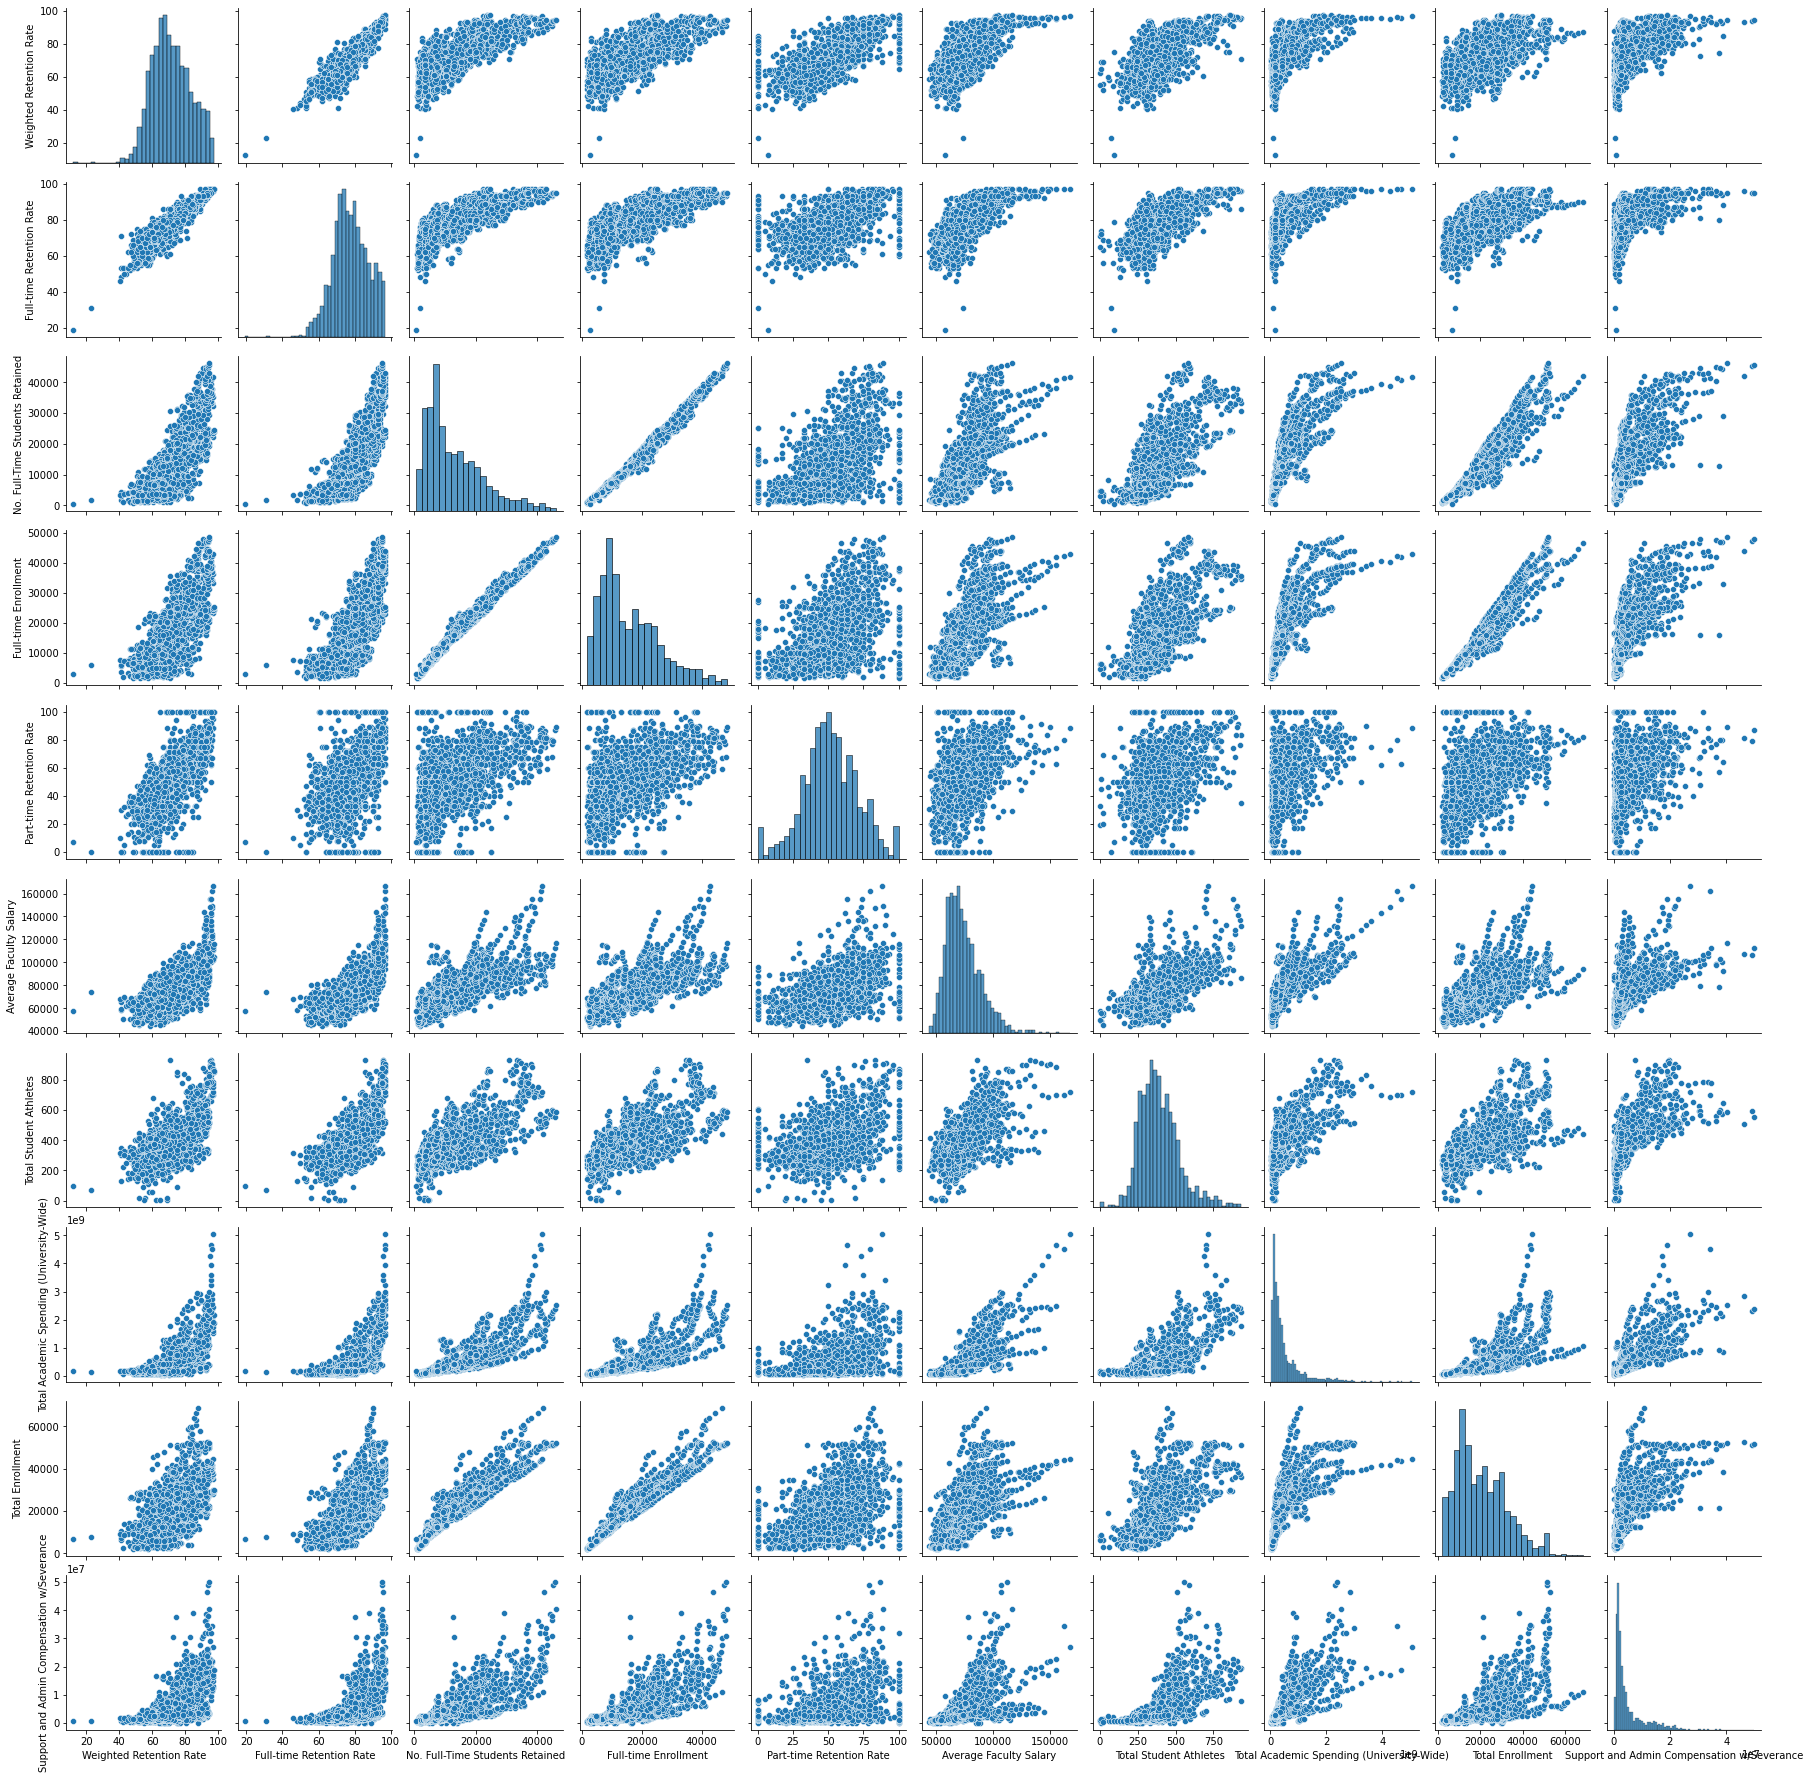

In [38]:
sns.pairplot(df,
             x_vars=top_10_corr,
             y_vars=top_10_corr
);

## Analyzing Trends

In [39]:
# Creating a new copy of the original df
df_time = df

In [40]:
# Converting "survey year" to date time
df_time['Survey Year'] = pd.to_datetime(df_time['Survey Year'], format='%Y')

In [41]:
# Setting new date time object as the index
df_time = df_time.set_index('Survey Year')

In [42]:
# Using group by to create medians for evey column in df
trends = df_time.groupby('Survey Year').median()

2.8700000000000045


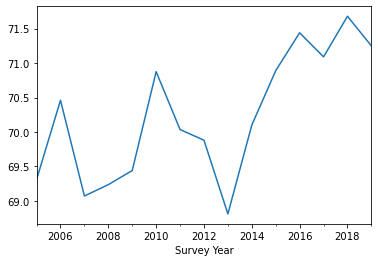

In [43]:
# Looking at weighted retention rate (target).
# Relatively consistent over the years (only ~2.87% increase)
print(trends['Weighted Retention Rate'].max() - trends['Weighted Retention Rate'].min())
trends['Weighted Retention Rate'].plot();

9060.055


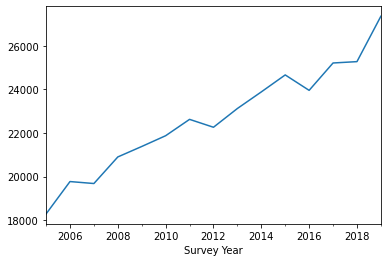

In [44]:
# Looking at academic spending per student
# Median increase about $9060 over 15 years
print(trends['Academic Spending per FTE Student'].max() - trends['Academic Spending per FTE Student'].min())
trends['Academic Spending per FTE Student'].plot();

33536.31


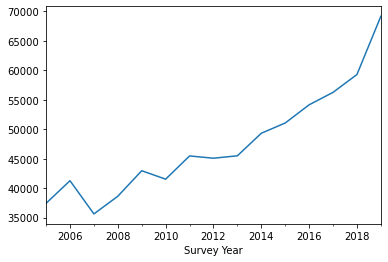

In [45]:
# Looking at athletic spending per athlete
# Median increase about $33,536 over 15 years
print(trends['Athletic Spending per Student Athlete'].max() - trends['Athletic Spending per Student Athlete'].min())
trends['Athletic Spending per Student Athlete'].plot();

175372124.0


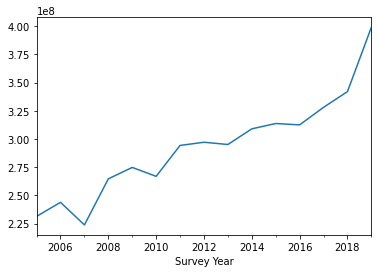

In [46]:
# Looking at total academic spending
# Median increase about $175,372,124 over 15 years
print(trends['Total Academic Spending (University-Wide)'].max() - trends['Total Academic Spending (University-Wide)'].min())
trends['Total Academic Spending (University-Wide)'].plot();

15786010.0


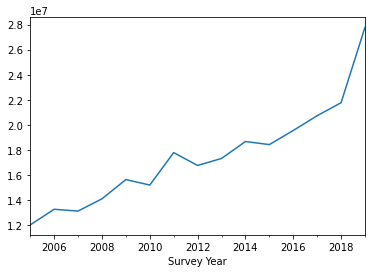

In [47]:
# Looking at total athletic spending
# Median increase about $15,786,010 over 15 years
print(trends['Grand Total Expenses'].max() - trends['Grand Total Expenses'].min())
trends['Grand Total Expenses'].plot();

16475395.0


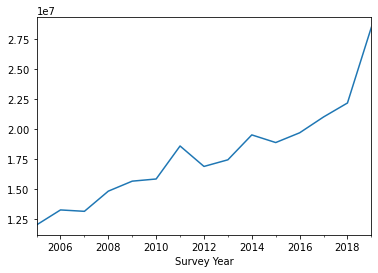

In [48]:
# Looking at total athletic revenues
# Median increase about $16,475,395 over 15 years
print(trends['Grand Total Revenue'].max() - trends['Grand Total Revenue'].min())
trends['Grand Total Revenue'].plot();

6449374.0


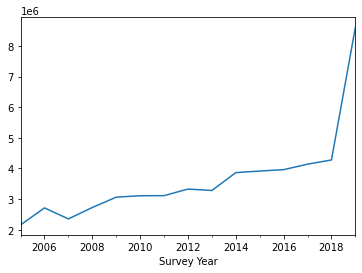

In [49]:
# Looking at total football spending
# Median increase about $6,449,374 over 15 years
print(trends['Total Football Spending'].max() - trends['Total Football Spending'].min())
trends['Total Football Spending'].plot();

1528877.0


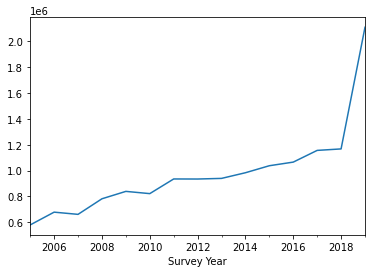

In [50]:
# Looking at total football coach salaries
# Median increase about $1,528,877 over 15 years
print(trends['Total Football Coaching Salaries'].max() - trends['Total Football Coaching Salaries'].min())
trends['Total Football Coaching Salaries'].plot();

1617863.0


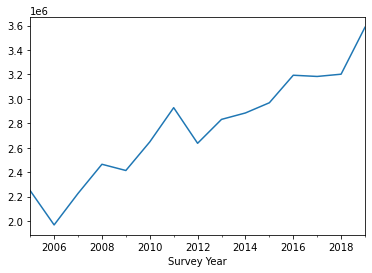

In [51]:
# Looking at student fees
# Median increase about $1,617,863 over 15 years
print(trends['Student Fees'].max() - trends['Student Fees'].min())
trends['Student Fees'].plot();

0.6169786723409829


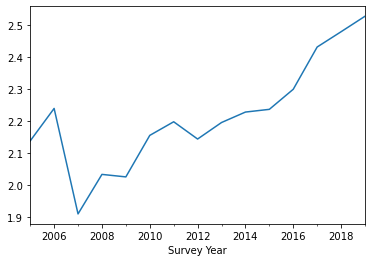

In [52]:
# Looking at ratio of athletic vs academic spending
# Median increase about 61% over 15 years
print(trends['Ratio of Athletic Spending vs. Academic Spending'].max() - trends['Ratio of Athletic Spending vs. Academic Spending'].min())
trends['Ratio of Athletic Spending vs. Academic Spending'].plot();

3.0


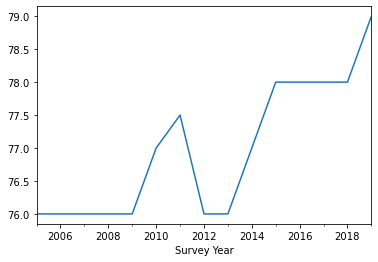

In [53]:
# Looking at full-time retention rates
# Median increase about 3% over 15 years
print(trends['Full-time Retention Rate'].max() - trends['Full-time Retention Rate'].min())
trends['Full-time Retention Rate'].plot();

4.0


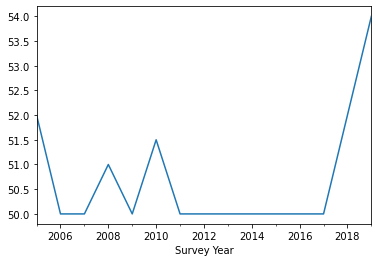

In [54]:
# Looking at part-time retention rates
# Median increase about 4% over 15 years
print(trends['Part-time Retention Rate'].max() - trends['Part-time Retention Rate'].min())
trends['Part-time Retention Rate'].plot();

4453084.0


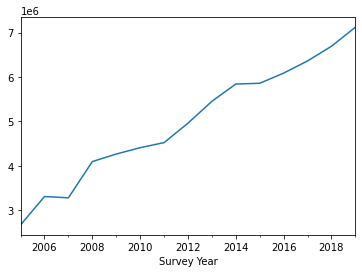

In [55]:
# Looking at institutional/goverment support
# Increase less significant than academic/athletic spending metrics ($4,453,084)
print(trends['Institutional/Government Support'].max() - trends['Institutional/Government Support'].min())
trends['Institutional/Government Support'].plot();

20498.0


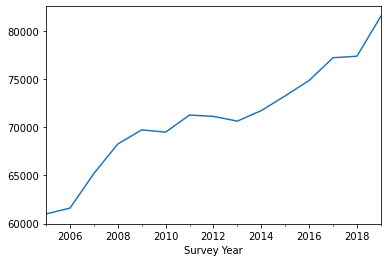

In [56]:
# Looking at average faculty salaries
# Increase less significant than athletic ($20,498)
print(trends['Average Faculty Salary'].max() - trends['Average Faculty Salary'].min())
trends['Average Faculty Salary'].plot();

123104204.0


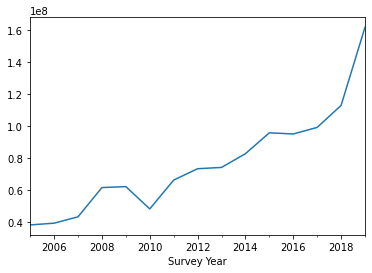

In [57]:
# Looking at endowments
# Increase pretty significant ($123,104,204)
print(trends['Endowment'].max() - trends['Endowment'].min())
trends['Endowment'].plot();

#### Doing similar trend analysis but for each NCAA Subdivision

In [58]:
# Replacing one Division II value with FCS (new term for conference)
df['NCAA Subdivision'].replace(to_replace='Division II', value='Football Championship Subdivision', inplace=True)

In [59]:
fbs = df[df['NCAA Subdivision'] == 'Football Bowl Subdivision']
fcs = df[df['NCAA Subdivision'] == 'Football Championship Subdivision']
nfs = df[df['NCAA Subdivision'] == 'No Football Subdivision']

In [60]:
fbs['Survey Year'] = pd.to_datetime(fbs['Survey Year'], format='%Y')
fcs['Survey Year'] = pd.to_datetime(fcs['Survey Year'], format='%Y')
nfs['Survey Year'] = pd.to_datetime(nfs['Survey Year'], format='%Y')

<ipython-input-60-b4e968168294>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fbs['Survey Year'] = pd.to_datetime(fbs['Survey Year'], format='%Y')
<ipython-input-60-b4e968168294>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcs['Survey Year'] = pd.to_datetime(fcs['Survey Year'], format='%Y')
<ipython-input-60-b4e968168294>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [61]:
fbs = fbs.set_index('Survey Year')
fcs = fcs.set_index('Survey Year')
nfs = nfs.set_index('Survey Year')

In [62]:
fbs_trends = fbs.groupby('Survey Year').median()
fcs_trends = fcs.groupby('Survey Year').median()
nfs_trends = nfs.groupby('Survey Year').median()

FBS: 4.335000000000008
FCS: 2.9849999999999994
NFS: 7.140000000000001


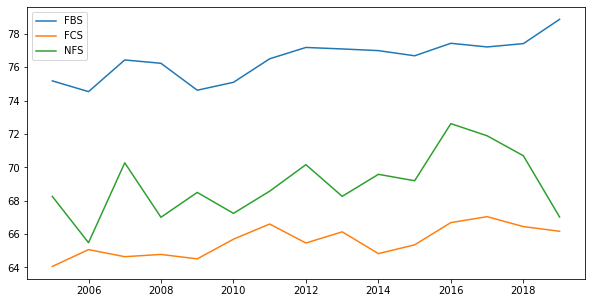

In [63]:
# Looking at weighted retention rate (target).
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Weighted Retention Rate'].max() - fbs_trends['Weighted Retention Rate'].min())
print('FCS:',fcs_trends['Weighted Retention Rate'].max() - fcs_trends['Weighted Retention Rate'].min())
print('NFS:',nfs_trends['Weighted Retention Rate'].max() - nfs_trends['Weighted Retention Rate'].min())
plt.plot(fbs_trends['Weighted Retention Rate'], label='FBS')
plt.plot(fcs_trends['Weighted Retention Rate'], label='FCS')
plt.plot(nfs_trends['Weighted Retention Rate'], label='NFS')
plt.legend();

FBS: 7528.75
FCS: 8496.545
NFS: 13473.13


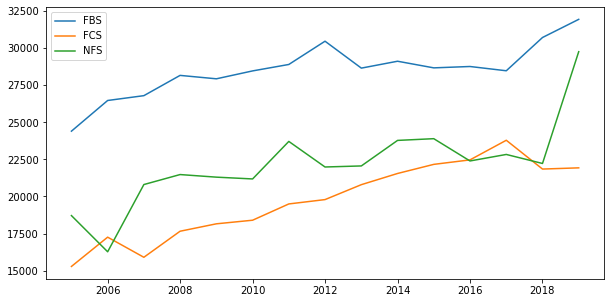

In [64]:
# Looking at academic spending per student
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Academic Spending per FTE Student'].max() - fbs_trends['Academic Spending per FTE Student'].min())
print('FCS:',fcs_trends['Academic Spending per FTE Student'].max() - fcs_trends['Academic Spending per FTE Student'].min())
print('NFS:',nfs_trends['Academic Spending per FTE Student'].max() - nfs_trends['Academic Spending per FTE Student'].min())
plt.plot(fbs_trends['Academic Spending per FTE Student'], label='FBS')
plt.plot(fcs_trends['Academic Spending per FTE Student'], label='FCS')
plt.plot(nfs_trends['Academic Spending per FTE Student'], label='NFS')
plt.legend();

FBS: 49112.59999999999
FCS: 19645.685000000005
NFS: 23009.184999999998


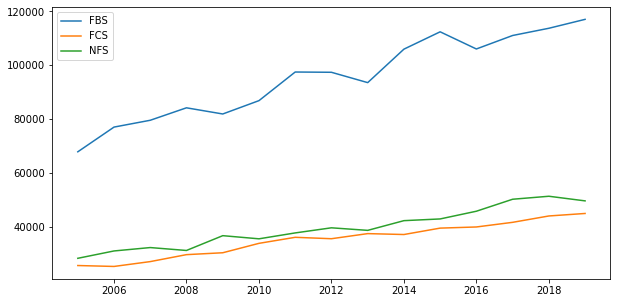

In [65]:
# Looking at athletic spending per student athlete
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Athletic Spending per Student Athlete'].max() - fbs_trends['Athletic Spending per Student Athlete'].min())
print('FCS:',fcs_trends['Athletic Spending per Student Athlete'].max() - fcs_trends['Athletic Spending per Student Athlete'].min())
print('NFS:',nfs_trends['Athletic Spending per Student Athlete'].max() - nfs_trends['Athletic Spending per Student Athlete'].min())
plt.plot(fbs_trends['Athletic Spending per Student Athlete'], label='FBS')
plt.plot(fcs_trends['Athletic Spending per Student Athlete'], label='FCS')
plt.plot(nfs_trends['Athletic Spending per Student Athlete'], label='NFS')
plt.legend();

FBS: 323506123.0
FCS: 71775169.41
NFS: 110993128.5


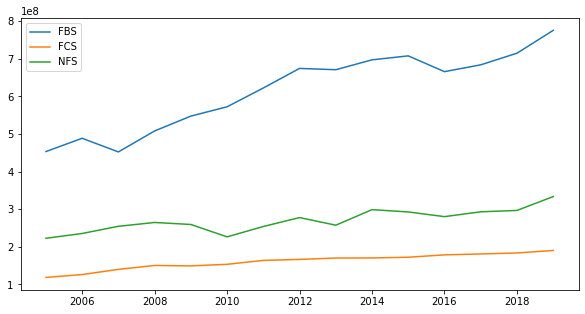

In [66]:
# Looking at total academic spending
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Total Academic Spending (University-Wide)'].max() - fbs_trends['Total Academic Spending (University-Wide)'].min())
print('FCS:',fcs_trends['Total Academic Spending (University-Wide)'].max() - fcs_trends['Total Academic Spending (University-Wide)'].min())
print('NFS:',nfs_trends['Total Academic Spending (University-Wide)'].max() - nfs_trends['Total Academic Spending (University-Wide)'].min())
plt.plot(fbs_trends['Total Academic Spending (University-Wide)'], label='FBS')
plt.plot(fcs_trends['Total Academic Spending (University-Wide)'], label='FCS')
plt.plot(nfs_trends['Total Academic Spending (University-Wide)'], label='NFS')
plt.legend();

FBS: 26218008.5
FCS: 8381785.5
NFS: 8736721.5


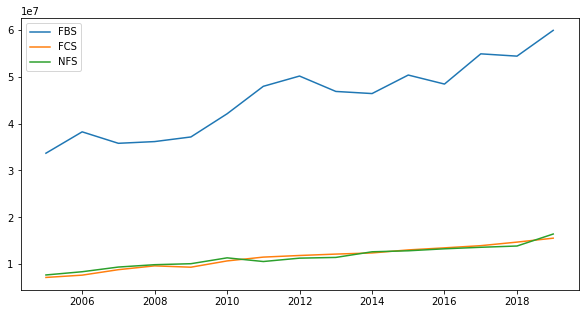

In [67]:
# Looking at total athletic spending
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Grand Total Expenses'].max() - fbs_trends['Grand Total Expenses'].min())
print('FCS:',fcs_trends['Grand Total Expenses'].max() - fcs_trends['Grand Total Expenses'].min())
print('NFS:',nfs_trends['Grand Total Expenses'].max() - nfs_trends['Grand Total Expenses'].min())
plt.plot(fbs_trends['Grand Total Expenses'], label='FBS')
plt.plot(fcs_trends['Grand Total Expenses'], label='FCS')
plt.plot(nfs_trends['Grand Total Expenses'], label='NFS')
plt.legend();

FBS: 22845074.5
FCS: 7963772.0
NFS: 8520954.5


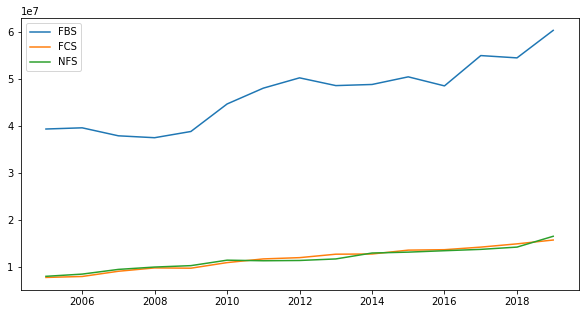

In [68]:
# Looking at total athletic revenues
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Grand Total Revenue'].max() - fbs_trends['Grand Total Revenue'].min())
print('FCS:',fcs_trends['Grand Total Revenue'].max() - fcs_trends['Grand Total Revenue'].min())
print('NFS:',nfs_trends['Grand Total Revenue'].max() - nfs_trends['Grand Total Revenue'].min())
plt.plot(fbs_trends['Grand Total Revenue'], label='FBS')
plt.plot(fcs_trends['Grand Total Revenue'], label='FCS')
plt.plot(nfs_trends['Grand Total Revenue'], label='NFS')
plt.legend();

FBS: 11239404.0
FCS: 2466097.5


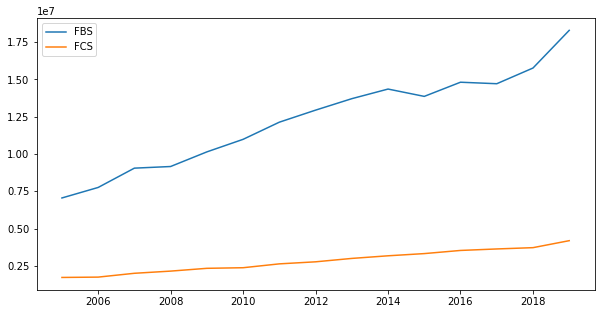

In [69]:
# Looking at total football spending (No NFS because they don't have football)
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Total Football Spending'].max() - fbs_trends['Total Football Spending'].min())
print('FCS:',fcs_trends['Total Football Spending'].max() - fcs_trends['Total Football Spending'].min())
plt.plot(fbs_trends['Total Football Spending'], label='FBS')
plt.plot(fcs_trends['Total Football Spending'], label='FCS')
plt.legend();

FBS: 3508416.0
FCS: 566081.5


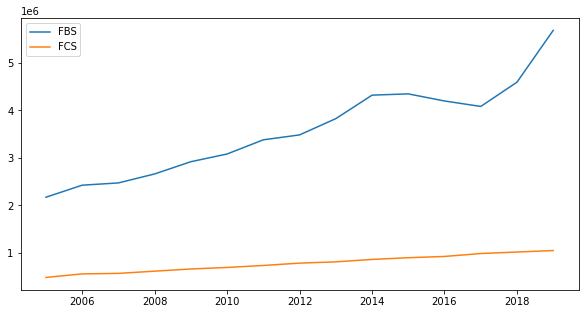

In [70]:
# Looking at total football spending (No NFS because they don't have football)
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Total Football Coaching Salaries'].max() - fbs_trends['Total Football Coaching Salaries'].min())
print('FCS:',fcs_trends['Total Football Coaching Salaries'].max() - fcs_trends['Total Football Coaching Salaries'].min())
plt.plot(fbs_trends['Total Football Coaching Salaries'], label='FBS')
plt.plot(fcs_trends['Total Football Coaching Salaries'], label='FCS')
plt.legend();

FBS: 1957729.5
FCS: 1308993.5
NFS: 1846748.0


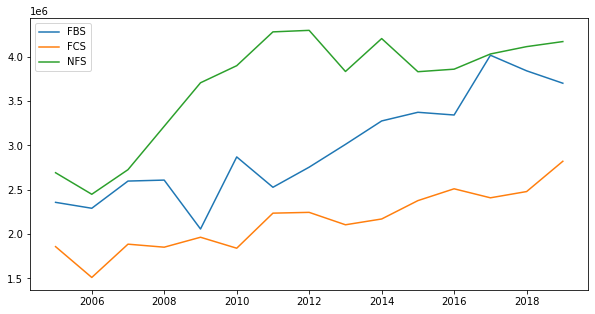

In [71]:
# Looking at student fees
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Student Fees'].max() - fbs_trends['Student Fees'].min())
print('FCS:',fcs_trends['Student Fees'].max() - fcs_trends['Student Fees'].min())
print('NFS:',nfs_trends['Student Fees'].max() - nfs_trends['Student Fees'].min())
plt.plot(fbs_trends['Student Fees'], label='FBS')
plt.plot(fcs_trends['Student Fees'], label='FCS')
plt.plot(nfs_trends['Student Fees'], label='NFS')
plt.legend();

FBS: 1.1346305136858579
FCS: 0.44523993785140314
NFS: 0.5551458322549636


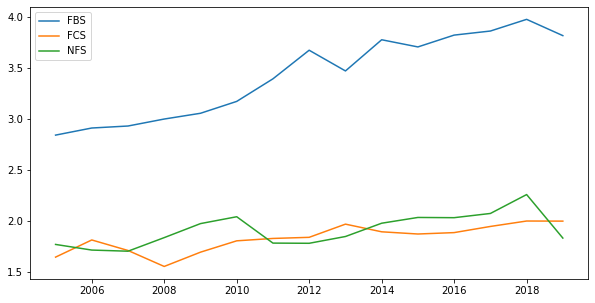

In [72]:
# Looking at ratio of athletic vs. academic spending
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Ratio of Athletic Spending vs. Academic Spending'].max() - fbs_trends['Ratio of Athletic Spending vs. Academic Spending'].min())
print('FCS:',fcs_trends['Ratio of Athletic Spending vs. Academic Spending'].max() - fcs_trends['Ratio of Athletic Spending vs. Academic Spending'].min())
print('NFS:',nfs_trends['Ratio of Athletic Spending vs. Academic Spending'].max() - nfs_trends['Ratio of Athletic Spending vs. Academic Spending'].min())
plt.plot(fbs_trends['Ratio of Athletic Spending vs. Academic Spending'], label='FBS')
plt.plot(fcs_trends['Ratio of Athletic Spending vs. Academic Spending'], label='FCS')
plt.plot(nfs_trends['Ratio of Athletic Spending vs. Academic Spending'], label='NFS')
plt.legend();

FBS: 3.0
FCS: 4.5
NFS: 4.0


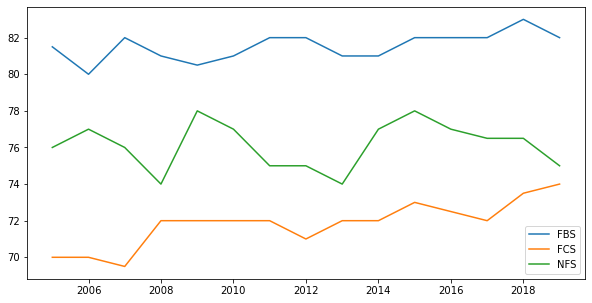

In [73]:
# Looking at full-time retention
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Full-time Retention Rate'].max() - fbs_trends['Full-time Retention Rate'].min())
print('FCS:',fcs_trends['Full-time Retention Rate'].max() - fcs_trends['Full-time Retention Rate'].min())
print('NFS:',nfs_trends['Full-time Retention Rate'].max() - nfs_trends['Full-time Retention Rate'].min())
plt.plot(fbs_trends['Full-time Retention Rate'], label='FBS')
plt.plot(fcs_trends['Full-time Retention Rate'], label='FCS')
plt.plot(nfs_trends['Full-time Retention Rate'], label='NFS')
plt.legend();

FBS: 8.5
FCS: 9.0
NFS: 14.0


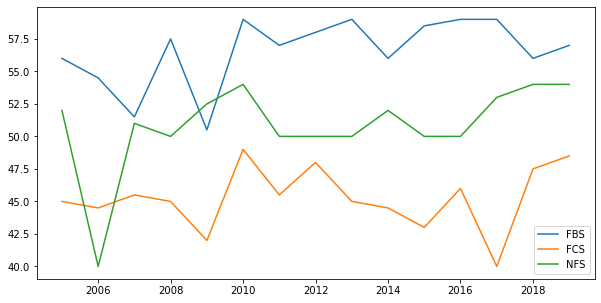

In [74]:
# Looking at part-time retention
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Part-time Retention Rate'].max() - fbs_trends['Part-time Retention Rate'].min())
print('FCS:',fcs_trends['Part-time Retention Rate'].max() - fcs_trends['Part-time Retention Rate'].min())
print('NFS:',nfs_trends['Part-time Retention Rate'].max() - nfs_trends['Part-time Retention Rate'].min())
plt.plot(fbs_trends['Part-time Retention Rate'], label='FBS')
plt.plot(fcs_trends['Part-time Retention Rate'], label='FCS')
plt.plot(nfs_trends['Part-time Retention Rate'], label='NFS')
plt.legend();

FBS: 20159.0
FCS: 14948.5
NFS: 17659.0


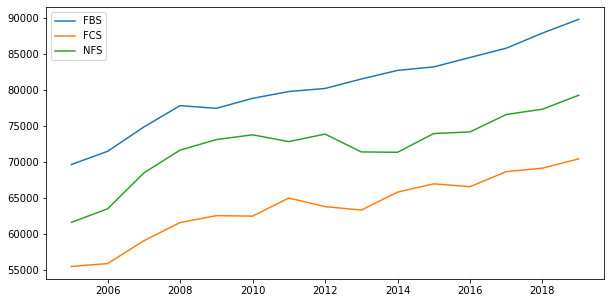

In [75]:
# Looking at part-time retention
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Average Faculty Salary'].max() - fbs_trends['Average Faculty Salary'].min())
print('FCS:',fcs_trends['Average Faculty Salary'].max() - fcs_trends['Average Faculty Salary'].min())
print('NFS:',nfs_trends['Average Faculty Salary'].max() - nfs_trends['Average Faculty Salary'].min())
plt.plot(fbs_trends['Average Faculty Salary'], label='FBS')
plt.plot(fcs_trends['Average Faculty Salary'], label='FCS')
plt.plot(nfs_trends['Average Faculty Salary'], label='NFS')
plt.legend();

FBS: 4716475.5
FCS: 4640594.5
NFS: 3596466.5


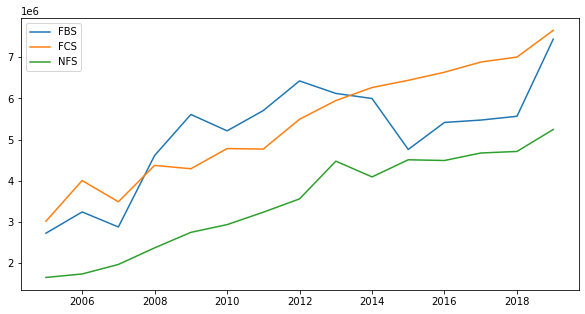

In [76]:
# Looking at institutional/government support
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Institutional/Government Support'].max() - fbs_trends['Institutional/Government Support'].min())
print('FCS:',fcs_trends['Institutional/Government Support'].max() - fcs_trends['Institutional/Government Support'].min())
print('NFS:',nfs_trends['Institutional/Government Support'].max() - nfs_trends['Institutional/Government Support'].min())
plt.plot(fbs_trends['Institutional/Government Support'], label='FBS')
plt.plot(fcs_trends['Institutional/Government Support'], label='FCS')
plt.plot(nfs_trends['Institutional/Government Support'], label='NFS')
plt.legend();

FBS: 358174100.5
FCS: 64617947.5
NFS: 73767079.0


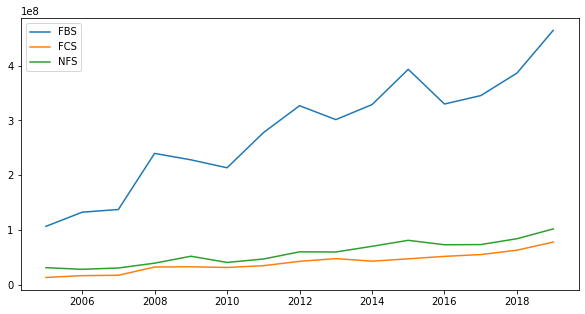

In [77]:
# Looking at endowments
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Endowment'].max() - fbs_trends['Endowment'].min())
print('FCS:',fcs_trends['Endowment'].max() - fcs_trends['Endowment'].min())
print('NFS:',nfs_trends['Endowment'].max() - nfs_trends['Endowment'].min())
plt.plot(fbs_trends['Endowment'], label='FBS')
plt.plot(fcs_trends['Endowment'], label='FCS')
plt.plot(nfs_trends['Endowment'], label='NFS')
plt.legend();

#### One more breakdown of the original df into each FBS conference

In [78]:
df['FBS Conference'].value_counts()

N/A                             1232
Conference USA                   132
Southeastern Conference           94
Mountain West Conference          88
Sun Belt Conference               75
Atlantic Coast Conference         74
Big Ten Conference                72
Pacific-12 Conference             72
Big 12 Conference                 71
Mid-American Conference           64
Western Athletic Conference       52
American Athletic Conference      30
Big East Conference               23
Name: FBS Conference, dtype: int64

In [79]:
cusa = df[df['FBS Conference'] == 'Conference USA']
sec = df[df['FBS Conference'] == 'Southeastern Conference']
mwc = df[df['FBS Conference'] == 'Mountain West Conference']
sb = df[df['FBS Conference'] == 'Sun Belt Conference']
acc = df[df['FBS Conference'] == 'Atlantic Coast Conference']
b10 = df[df['FBS Conference'] == 'Big Ten Conference']
pac12 = df[df['FBS Conference'] == 'Pacific-12 Conference']
b12 = df[df['FBS Conference'] == 'Big 12 Conference']
mac = df[df['FBS Conference'] == 'Mid-American Conference']
wac = df[df['FBS Conference'] == 'Western Athletic Conference']
aac = df[df['FBS Conference'] == 'American Athletic Conference']
beast = df[df['FBS Conference'] == 'Big East Conference']

In [80]:
cusa['Survey Year'] = pd.to_datetime(cusa['Survey Year'], format='%Y')
sec['Survey Year'] = pd.to_datetime(sec['Survey Year'], format='%Y')
mwc['Survey Year'] = pd.to_datetime(mwc['Survey Year'], format='%Y')
sb['Survey Year'] = pd.to_datetime(sb['Survey Year'], format='%Y')
acc['Survey Year'] = pd.to_datetime(acc['Survey Year'], format='%Y')
b10['Survey Year'] = pd.to_datetime(b10['Survey Year'], format='%Y')
pac12['Survey Year'] = pd.to_datetime(pac12['Survey Year'], format='%Y')
b12['Survey Year'] = pd.to_datetime(b12['Survey Year'], format='%Y')
mac['Survey Year'] = pd.to_datetime(mac['Survey Year'], format='%Y')
wac['Survey Year'] = pd.to_datetime(wac['Survey Year'], format='%Y')
aac['Survey Year'] = pd.to_datetime(aac['Survey Year'], format='%Y')
beast['Survey Year'] = pd.to_datetime(beast['Survey Year'], format='%Y')

<ipython-input-80-890ad05f65e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cusa['Survey Year'] = pd.to_datetime(cusa['Survey Year'], format='%Y')
<ipython-input-80-890ad05f65e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sec['Survey Year'] = pd.to_datetime(sec['Survey Year'], format='%Y')
<ipython-input-80-890ad05f65e0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [81]:
cusa = cusa.set_index('Survey Year')
sec = sec.set_index('Survey Year')
mwc = mwc.set_index('Survey Year')
sb = sb.set_index('Survey Year')
acc = acc.set_index('Survey Year')
b10 = b10.set_index('Survey Year')
pac12 = pac12.set_index('Survey Year')
b12 = b12.set_index('Survey Year')
mac = mac.set_index('Survey Year')
wac = wac.set_index('Survey Year')
aac = aac.set_index('Survey Year')
beast = beast.set_index('Survey Year')

In [82]:
cusa_trends = cusa.groupby('Survey Year').median()
sec_trends = sec.groupby('Survey Year').median()
mwc_trends = mwc.groupby('Survey Year').median()
sb_trends = sb.groupby('Survey Year').median()
acc_trends = acc.groupby('Survey Year').median()
b10_trends = b10.groupby('Survey Year').median()
pac12_trends = pac12.groupby('Survey Year').median()
b12_trends = b12.groupby('Survey Year').median()
mac_trends = mac.groupby('Survey Year').median()
wac_trends = wac.groupby('Survey Year').median()
aac_trends = aac.groupby('Survey Year').median()
beast_trends = beast.groupby('Survey Year').median()

Conference USA: 10.585000000000008
Southeastern Conference: 5.609999999999999
Mountain West Conference: 11.745000000000005
Sunbelt Conference: 10.680000000000007
Atlantic Coast Conference: 6.284999999999997
Big 10 Conference: 5.135000000000005
Pac 12 Conference: 18.709999999999994
Big 12 Conference: 5.049999999999997
Mid-American Conference: 7.474999999999994
Western Athletic Conference: 9.695000000000007
American Athletic Conference: 2.0
Big East Conference: 8.25


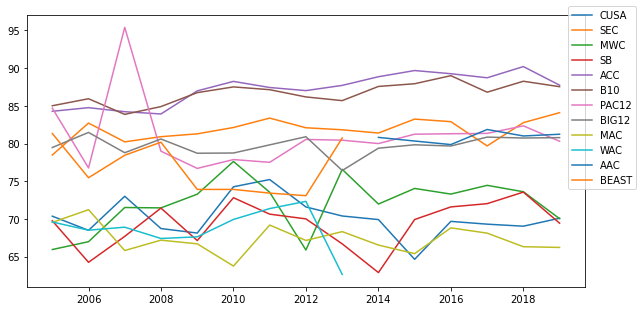

In [83]:
# Looking at weighted retention rate (target).
plt.subplots(figsize=(10,5))
print('Conference USA:',cusa_trends['Weighted Retention Rate'].max() - cusa_trends['Weighted Retention Rate'].min())
print('Southeastern Conference:',sec_trends['Weighted Retention Rate'].max() - sec_trends['Weighted Retention Rate'].min())
print('Mountain West Conference:',mwc_trends['Weighted Retention Rate'].max() - mwc_trends['Weighted Retention Rate'].min())
print('Sunbelt Conference:',sb_trends['Weighted Retention Rate'].max() - sb_trends['Weighted Retention Rate'].min())
print('Atlantic Coast Conference:',acc_trends['Weighted Retention Rate'].max() - acc_trends['Weighted Retention Rate'].min())
print('Big 10 Conference:',b10_trends['Weighted Retention Rate'].max() - b10_trends['Weighted Retention Rate'].min())
print('Pac 12 Conference:',pac12_trends['Weighted Retention Rate'].max() - pac12_trends['Weighted Retention Rate'].min())
print('Big 12 Conference:',b12_trends['Weighted Retention Rate'].max() - b12_trends['Weighted Retention Rate'].min())
print('Mid-American Conference:',mac_trends['Weighted Retention Rate'].max() - mac_trends['Weighted Retention Rate'].min())
print('Western Athletic Conference:',wac_trends['Weighted Retention Rate'].max() - wac_trends['Weighted Retention Rate'].min())
print('American Athletic Conference:',aac_trends['Weighted Retention Rate'].max() - aac_trends['Weighted Retention Rate'].min())
print('Big East Conference:',beast_trends['Weighted Retention Rate'].max() - beast_trends['Weighted Retention Rate'].min())
plt.plot(cusa_trends['Weighted Retention Rate'], label='CUSA')
plt.plot(sec_trends['Weighted Retention Rate'], label='SEC')
plt.plot(mwc_trends['Weighted Retention Rate'], label='MWC')
plt.plot(sb_trends['Weighted Retention Rate'], label='SB')
plt.plot(acc_trends['Weighted Retention Rate'], label='ACC')
plt.plot(b10_trends['Weighted Retention Rate'], label='B10')
plt.plot(pac12_trends['Weighted Retention Rate'], label='PAC12')
plt.plot(b12_trends['Weighted Retention Rate'], label='BIG12')
plt.plot(mac_trends['Weighted Retention Rate'], label='MAC')
plt.plot(wac_trends['Weighted Retention Rate'], label='WAC')
plt.plot(aac_trends['Weighted Retention Rate'], label='AAC')
plt.plot(beast_trends['Weighted Retention Rate'], label='BEAST')
plt.legend(bbox_to_anchor=(1.1, 1.05));

Conference USA: 3836.7350000000006
Southeastern Conference: 5158.93
Mountain West Conference: 14196.995000000003
Sunbelt Conference: 10505.920000000002
Atlantic Coast Conference: 14932.169999999998
Big 10 Conference: 24897.82
Pac 12 Conference: 31285.6
Big 12 Conference: 8427.530000000002
Mid-American Conference: 8724.73
Western Athletic Conference: 8690.385
American Athletic Conference: 3224.3099999999977
Big East Conference: 23455.205


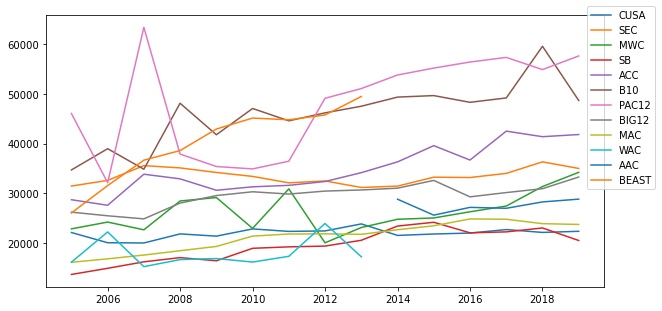

In [84]:
# Looking at academic spending per student
plt.subplots(figsize=(10,5))
print('Conference USA:',cusa_trends['Academic Spending per FTE Student'].max() - cusa_trends['Academic Spending per FTE Student'].min())
print('Southeastern Conference:',sec_trends['Academic Spending per FTE Student'].max() - sec_trends['Academic Spending per FTE Student'].min())
print('Mountain West Conference:',mwc_trends['Academic Spending per FTE Student'].max() - mwc_trends['Academic Spending per FTE Student'].min())
print('Sunbelt Conference:',sb_trends['Academic Spending per FTE Student'].max() - sb_trends['Academic Spending per FTE Student'].min())
print('Atlantic Coast Conference:',acc_trends['Academic Spending per FTE Student'].max() - acc_trends['Academic Spending per FTE Student'].min())
print('Big 10 Conference:',b10_trends['Academic Spending per FTE Student'].max() - b10_trends['Academic Spending per FTE Student'].min())
print('Pac 12 Conference:',pac12_trends['Academic Spending per FTE Student'].max() - pac12_trends['Academic Spending per FTE Student'].min())
print('Big 12 Conference:',b12_trends['Academic Spending per FTE Student'].max() - b12_trends['Academic Spending per FTE Student'].min())
print('Mid-American Conference:',mac_trends['Academic Spending per FTE Student'].max() - mac_trends['Academic Spending per FTE Student'].min())
print('Western Athletic Conference:',wac_trends['Academic Spending per FTE Student'].max() - wac_trends['Academic Spending per FTE Student'].min())
print('American Athletic Conference:',aac_trends['Academic Spending per FTE Student'].max() - aac_trends['Academic Spending per FTE Student'].min())
print('Big East Conference:',beast_trends['Academic Spending per FTE Student'].max() - beast_trends['Academic Spending per FTE Student'].min())
plt.plot(cusa_trends['Academic Spending per FTE Student'], label='CUSA')
plt.plot(sec_trends['Academic Spending per FTE Student'], label='SEC')
plt.plot(mwc_trends['Academic Spending per FTE Student'], label='MWC')
plt.plot(sb_trends['Academic Spending per FTE Student'], label='SB')
plt.plot(acc_trends['Academic Spending per FTE Student'], label='ACC')
plt.plot(b10_trends['Academic Spending per FTE Student'], label='B10')
plt.plot(pac12_trends['Academic Spending per FTE Student'], label='PAC12')
plt.plot(b12_trends['Academic Spending per FTE Student'], label='BIG12')
plt.plot(mac_trends['Academic Spending per FTE Student'], label='MAC')
plt.plot(wac_trends['Academic Spending per FTE Student'], label='WAC')
plt.plot(aac_trends['Academic Spending per FTE Student'], label='AAC')
plt.plot(beast_trends['Academic Spending per FTE Student'], label='BEAST')
plt.legend(bbox_to_anchor=(1.1, 1.05));

Conference USA: 31740.395000000004
Southeastern Conference: 147931.38
Mountain West Conference: 49240.235
Sunbelt Conference: 30653.895000000004
Atlantic Coast Conference: 138271.52500000002
Big 10 Conference: 103807.15999999999
Pac 12 Conference: 81089.08499999998
Big 12 Conference: 103157.07
Mid-American Conference: 29112.975000000006
Western Athletic Conference: 17831.020000000004
American Athletic Conference: 28733.809999999983
Big East Conference: 76023.52


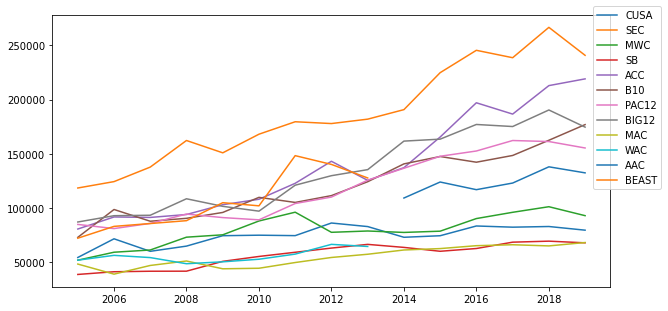

In [85]:
# Looking at athletic spending per student athlete
# SEC is highest in athlete spending and lowest in academic spending (of power 5 conferences)
plt.subplots(figsize=(10,5))
print('Conference USA:',cusa_trends['Athletic Spending per Student Athlete'].max() - cusa_trends['Athletic Spending per Student Athlete'].min())
print('Southeastern Conference:',sec_trends['Athletic Spending per Student Athlete'].max() - sec_trends['Athletic Spending per Student Athlete'].min())
print('Mountain West Conference:',mwc_trends['Athletic Spending per Student Athlete'].max() - mwc_trends['Athletic Spending per Student Athlete'].min())
print('Sunbelt Conference:',sb_trends['Athletic Spending per Student Athlete'].max() - sb_trends['Athletic Spending per Student Athlete'].min())
print('Atlantic Coast Conference:',acc_trends['Athletic Spending per Student Athlete'].max() - acc_trends['Athletic Spending per Student Athlete'].min())
print('Big 10 Conference:',b10_trends['Athletic Spending per Student Athlete'].max() - b10_trends['Athletic Spending per Student Athlete'].min())
print('Pac 12 Conference:',pac12_trends['Athletic Spending per Student Athlete'].max() - pac12_trends['Athletic Spending per Student Athlete'].min())
print('Big 12 Conference:',b12_trends['Athletic Spending per Student Athlete'].max() - b12_trends['Athletic Spending per Student Athlete'].min())
print('Mid-American Conference:',mac_trends['Athletic Spending per Student Athlete'].max() - mac_trends['Athletic Spending per Student Athlete'].min())
print('Western Athletic Conference:',wac_trends['Athletic Spending per Student Athlete'].max() - wac_trends['Athletic Spending per Student Athlete'].min())
print('American Athletic Conference:',aac_trends['Athletic Spending per Student Athlete'].max() - aac_trends['Athletic Spending per Student Athlete'].min())
print('Big East Conference:',beast_trends['Athletic Spending per Student Athlete'].max() - beast_trends['Athletic Spending per Student Athlete'].min())
plt.plot(cusa_trends['Athletic Spending per Student Athlete'], label='CUSA')
plt.plot(sec_trends['Athletic Spending per Student Athlete'], label='SEC')
plt.plot(mwc_trends['Athletic Spending per Student Athlete'], label='MWC')
plt.plot(sb_trends['Athletic Spending per Student Athlete'], label='SB')
plt.plot(acc_trends['Athletic Spending per Student Athlete'], label='ACC')
plt.plot(b10_trends['Athletic Spending per Student Athlete'], label='B10')
plt.plot(pac12_trends['Athletic Spending per Student Athlete'], label='PAC12')
plt.plot(b12_trends['Athletic Spending per Student Athlete'], label='BIG12')
plt.plot(mac_trends['Athletic Spending per Student Athlete'], label='MAC')
plt.plot(wac_trends['Athletic Spending per Student Athlete'], label='WAC')
plt.plot(aac_trends['Athletic Spending per Student Athlete'], label='AAC')
plt.plot(beast_trends['Athletic Spending per Student Athlete'], label='BEAST')
plt.legend(bbox_to_anchor=(1.1, 1.05));

Conference USA: 143572038.5
Southeastern Conference: 150306463.0
Mountain West Conference: 269746099.0
Sunbelt Conference: 97039872.0
Atlantic Coast Conference: 517947807.5
Big 10 Conference: 1272818634.5
Pac 12 Conference: 1452131194.5
Big 12 Conference: 381170576.0
Mid-American Conference: 102826364.0
Western Athletic Conference: 169008102.5
American Athletic Conference: 206197259.0
Big East Conference: 427754845.5


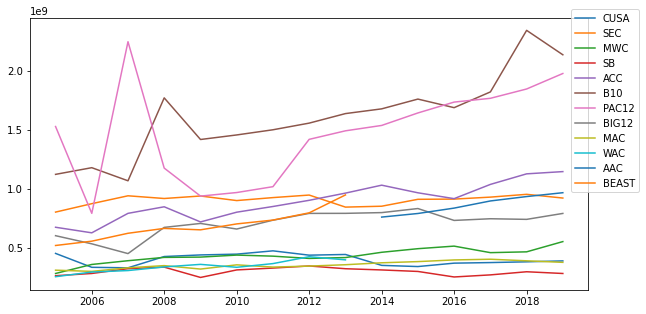

In [86]:
# Looking at total academic spending
plt.subplots(figsize=(10,5))
print('Conference USA:',cusa_trends['Total Academic Spending (University-Wide)'].max() - cusa_trends['Total Academic Spending (University-Wide)'].min())
print('Southeastern Conference:',sec_trends['Total Academic Spending (University-Wide)'].max() - sec_trends['Total Academic Spending (University-Wide)'].min())
print('Mountain West Conference:',mwc_trends['Total Academic Spending (University-Wide)'].max() - mwc_trends['Total Academic Spending (University-Wide)'].min())
print('Sunbelt Conference:',sb_trends['Total Academic Spending (University-Wide)'].max() - sb_trends['Total Academic Spending (University-Wide)'].min())
print('Atlantic Coast Conference:',acc_trends['Total Academic Spending (University-Wide)'].max() - acc_trends['Total Academic Spending (University-Wide)'].min())
print('Big 10 Conference:',b10_trends['Total Academic Spending (University-Wide)'].max() - b10_trends['Total Academic Spending (University-Wide)'].min())
print('Pac 12 Conference:',pac12_trends['Total Academic Spending (University-Wide)'].max() - pac12_trends['Total Academic Spending (University-Wide)'].min())
print('Big 12 Conference:',b12_trends['Total Academic Spending (University-Wide)'].max() - b12_trends['Total Academic Spending (University-Wide)'].min())
print('Mid-American Conference:',mac_trends['Total Academic Spending (University-Wide)'].max() - mac_trends['Total Academic Spending (University-Wide)'].min())
print('Western Athletic Conference:',wac_trends['Total Academic Spending (University-Wide)'].max() - wac_trends['Total Academic Spending (University-Wide)'].min())
print('American Athletic Conference:',aac_trends['Total Academic Spending (University-Wide)'].max() - aac_trends['Total Academic Spending (University-Wide)'].min())
print('Big East Conference:',beast_trends['Total Academic Spending (University-Wide)'].max() - beast_trends['Total Academic Spending (University-Wide)'].min())
plt.plot(cusa_trends['Total Academic Spending (University-Wide)'], label='CUSA')
plt.plot(sec_trends['Total Academic Spending (University-Wide)'], label='SEC')
plt.plot(mwc_trends['Total Academic Spending (University-Wide)'], label='MWC')
plt.plot(sb_trends['Total Academic Spending (University-Wide)'], label='SB')
plt.plot(acc_trends['Total Academic Spending (University-Wide)'], label='ACC')
plt.plot(b10_trends['Total Academic Spending (University-Wide)'], label='B10')
plt.plot(pac12_trends['Total Academic Spending (University-Wide)'], label='PAC12')
plt.plot(b12_trends['Total Academic Spending (University-Wide)'], label='BIG12')
plt.plot(mac_trends['Total Academic Spending (University-Wide)'], label='MAC')
plt.plot(wac_trends['Total Academic Spending (University-Wide)'], label='WAC')
plt.plot(aac_trends['Total Academic Spending (University-Wide)'], label='AAC')
plt.plot(beast_trends['Total Academic Spending (University-Wide)'], label='BEAST')
plt.legend(bbox_to_anchor=(1.1, 1.05));

Conference USA: 10186230.0
Southeastern Conference: 84528957.0
Mountain West Conference: 21049509.0
Sunbelt Conference: 14735376.0
Atlantic Coast Conference: 72951021.5
Big 10 Conference: 56882438.0
Pac 12 Conference: 45716600.0
Big 12 Conference: 43292830.0
Mid-American Conference: 15832184.5
Western Athletic Conference: 8816783.0
American Athletic Conference: 21868871
Big East Conference: 35442307.0


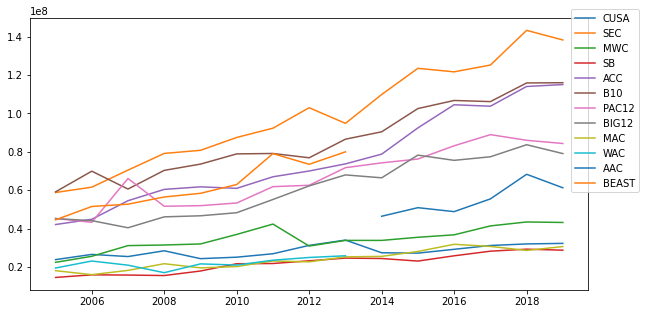

In [87]:
# Looking at total athletic spending
plt.subplots(figsize=(10,5))
print('Conference USA:',cusa_trends['Grand Total Expenses'].max() - cusa_trends['Grand Total Expenses'].min())
print('Southeastern Conference:',sec_trends['Grand Total Expenses'].max() - sec_trends['Grand Total Expenses'].min())
print('Mountain West Conference:',mwc_trends['Grand Total Expenses'].max() - mwc_trends['Grand Total Expenses'].min())
print('Sunbelt Conference:',sb_trends['Grand Total Expenses'].max() - sb_trends['Grand Total Expenses'].min())
print('Atlantic Coast Conference:',acc_trends['Grand Total Expenses'].max() - acc_trends['Grand Total Expenses'].min())
print('Big 10 Conference:',b10_trends['Grand Total Expenses'].max() - b10_trends['Grand Total Expenses'].min())
print('Pac 12 Conference:',pac12_trends['Grand Total Expenses'].max() - pac12_trends['Grand Total Expenses'].min())
print('Big 12 Conference:',b12_trends['Grand Total Expenses'].max() - b12_trends['Grand Total Expenses'].min())
print('Mid-American Conference:',mac_trends['Grand Total Expenses'].max() - mac_trends['Grand Total Expenses'].min())
print('Western Athletic Conference:',wac_trends['Grand Total Expenses'].max() - wac_trends['Grand Total Expenses'].min())
print('American Athletic Conference:',aac_trends['Grand Total Expenses'].max() - aac_trends['Grand Total Expenses'].min())
print('Big East Conference:',beast_trends['Grand Total Expenses'].max() - beast_trends['Grand Total Expenses'].min())
plt.plot(cusa_trends['Grand Total Expenses'], label='CUSA')
plt.plot(sec_trends['Grand Total Expenses'], label='SEC')
plt.plot(mwc_trends['Grand Total Expenses'], label='MWC')
plt.plot(sb_trends['Grand Total Expenses'], label='SB')
plt.plot(acc_trends['Grand Total Expenses'], label='ACC')
plt.plot(b10_trends['Grand Total Expenses'], label='B10')
plt.plot(pac12_trends['Grand Total Expenses'], label='PAC12')
plt.plot(b12_trends['Grand Total Expenses'], label='BIG12')
plt.plot(mac_trends['Grand Total Expenses'], label='MAC')
plt.plot(wac_trends['Grand Total Expenses'], label='WAC')
plt.plot(aac_trends['Grand Total Expenses'], label='AAC')
plt.plot(beast_trends['Grand Total Expenses'], label='BEAST')
plt.legend(bbox_to_anchor=(1.1, 1.05));

Conference USA: 10504547.5
Southeastern Conference: 76778510.0
Mountain West Conference: 21049509.0
Sunbelt Conference: 14065782.0
Atlantic Coast Conference: 70355796.0
Big 10 Conference: 59608963.0
Pac 12 Conference: 49046996.0
Big 12 Conference: 48897833.0
Mid-American Conference: 15589799.5
Western Athletic Conference: 8056080.0
American Athletic Conference: 19465148
Big East Conference: 30410900.0


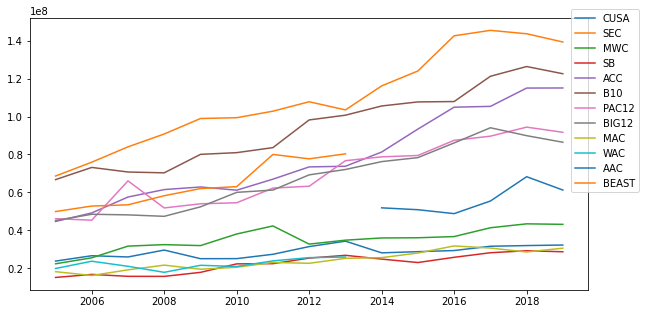

In [88]:
# Looking at total athletic revenues
plt.subplots(figsize=(10,5))
print('Conference USA:',cusa_trends['Grand Total Revenue'].max() - cusa_trends['Grand Total Revenue'].min())
print('Southeastern Conference:',sec_trends['Grand Total Revenue'].max() - sec_trends['Grand Total Revenue'].min())
print('Mountain West Conference:',mwc_trends['Grand Total Revenue'].max() - mwc_trends['Grand Total Revenue'].min())
print('Sunbelt Conference:',sb_trends['Grand Total Revenue'].max() - sb_trends['Grand Total Revenue'].min())
print('Atlantic Coast Conference:',acc_trends['Grand Total Revenue'].max() - acc_trends['Grand Total Revenue'].min())
print('Big 10 Conference:',b10_trends['Grand Total Revenue'].max() - b10_trends['Grand Total Revenue'].min())
print('Pac 12 Conference:',pac12_trends['Grand Total Revenue'].max() - pac12_trends['Grand Total Revenue'].min())
print('Big 12 Conference:',b12_trends['Grand Total Revenue'].max() - b12_trends['Grand Total Revenue'].min())
print('Mid-American Conference:',mac_trends['Grand Total Revenue'].max() - mac_trends['Grand Total Revenue'].min())
print('Western Athletic Conference:',wac_trends['Grand Total Revenue'].max() - wac_trends['Grand Total Revenue'].min())
print('American Athletic Conference:',aac_trends['Grand Total Revenue'].max() - aac_trends['Grand Total Revenue'].min())
print('Big East Conference:',beast_trends['Grand Total Revenue'].max() - beast_trends['Grand Total Revenue'].min())
plt.plot(cusa_trends['Grand Total Revenue'], label='CUSA')
plt.plot(sec_trends['Grand Total Revenue'], label='SEC')
plt.plot(mwc_trends['Grand Total Revenue'], label='MWC')
plt.plot(sb_trends['Grand Total Revenue'], label='SB')
plt.plot(acc_trends['Grand Total Revenue'], label='ACC')
plt.plot(b10_trends['Grand Total Revenue'], label='B10')
plt.plot(pac12_trends['Grand Total Revenue'], label='PAC12')
plt.plot(b12_trends['Grand Total Revenue'], label='BIG12')
plt.plot(mac_trends['Grand Total Revenue'], label='MAC')
plt.plot(wac_trends['Grand Total Revenue'], label='WAC')
plt.plot(aac_trends['Grand Total Revenue'], label='AAC')
plt.plot(beast_trends['Grand Total Revenue'], label='BEAST')
plt.legend(bbox_to_anchor=(1.1, 1.05));

Conference USA: 4971533.5
Southeastern Conference: 22786665.0
Mountain West Conference: 8687938.0
Sunbelt Conference: 5890020.0
Atlantic Coast Conference: 28870016.5
Big 10 Conference: 24674909.0
Pac 12 Conference: 23007574.0
Big 12 Conference: 19656881.0
Mid-American Conference: 4193134.5
Western Athletic Conference: 2231471.5
American Athletic Conference: 4822679.0
Big East Conference: 7948475.5


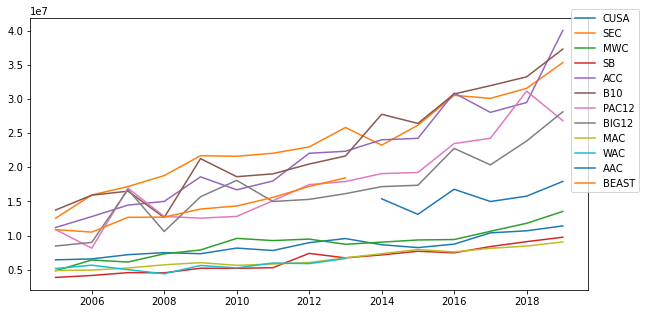

In [89]:
# Looking at total football spending
plt.subplots(figsize=(10,5))
print('Conference USA:',cusa_trends['Total Football Spending'].max() - cusa_trends['Total Football Spending'].min())
print('Southeastern Conference:',sec_trends['Total Football Spending'].max() - sec_trends['Total Football Spending'].min())
print('Mountain West Conference:',mwc_trends['Total Football Spending'].max() - mwc_trends['Total Football Spending'].min())
print('Sunbelt Conference:',sb_trends['Total Football Spending'].max() - sb_trends['Total Football Spending'].min())
print('Atlantic Coast Conference:',acc_trends['Total Football Spending'].max() - acc_trends['Total Football Spending'].min())
print('Big 10 Conference:',b10_trends['Total Football Spending'].max() - b10_trends['Total Football Spending'].min())
print('Pac 12 Conference:',pac12_trends['Total Football Spending'].max() - pac12_trends['Total Football Spending'].min())
print('Big 12 Conference:',b12_trends['Total Football Spending'].max() - b12_trends['Total Football Spending'].min())
print('Mid-American Conference:',mac_trends['Total Football Spending'].max() - mac_trends['Total Football Spending'].min())
print('Western Athletic Conference:',wac_trends['Total Football Spending'].max() - wac_trends['Total Football Spending'].min())
print('American Athletic Conference:',aac_trends['Total Football Spending'].max() - aac_trends['Total Football Spending'].min())
print('Big East Conference:',beast_trends['Total Football Spending'].max() - beast_trends['Total Football Spending'].min())
plt.plot(cusa_trends['Total Football Spending'], label='CUSA')
plt.plot(sec_trends['Total Football Spending'], label='SEC')
plt.plot(mwc_trends['Total Football Spending'], label='MWC')
plt.plot(sb_trends['Total Football Spending'], label='SB')
plt.plot(acc_trends['Total Football Spending'], label='ACC')
plt.plot(b10_trends['Total Football Spending'], label='B10')
plt.plot(pac12_trends['Total Football Spending'], label='PAC12')
plt.plot(b12_trends['Total Football Spending'], label='BIG12')
plt.plot(mac_trends['Total Football Spending'], label='MAC')
plt.plot(wac_trends['Total Football Spending'], label='WAC')
plt.plot(aac_trends['Total Football Spending'], label='AAC')
plt.plot(beast_trends['Total Football Spending'], label='BEAST')
plt.legend(bbox_to_anchor=(1.1, 1.05));

Conference USA: 1218722.0
Southeastern Conference: 10124721.0
Mountain West Conference: 2381264.5
Sunbelt Conference: 1690419.5
Atlantic Coast Conference: 7061356.0
Big 10 Conference: 6815800.0
Pac 12 Conference: 6102132.5
Big 12 Conference: 6217287.0
Mid-American Conference: 1299226.0
Western Athletic Conference: 449915.5
American Athletic Conference: 1229334.0
Big East Conference: 3343986.0


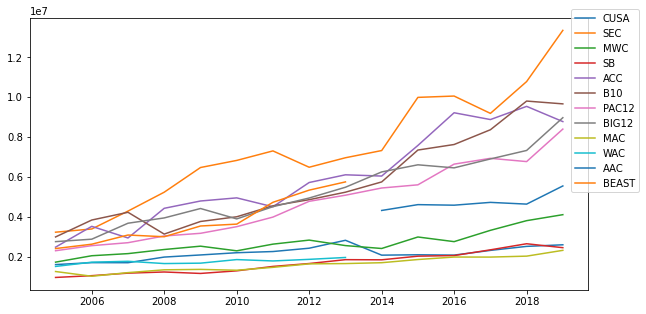

In [90]:
# Looking at total coaching salaries
plt.subplots(figsize=(10,5))
print('Conference USA:',cusa_trends['Total Football Coaching Salaries'].max() - cusa_trends['Total Football Coaching Salaries'].min())
print('Southeastern Conference:',sec_trends['Total Football Coaching Salaries'].max() - sec_trends['Total Football Coaching Salaries'].min())
print('Mountain West Conference:',mwc_trends['Total Football Coaching Salaries'].max() - mwc_trends['Total Football Coaching Salaries'].min())
print('Sunbelt Conference:',sb_trends['Total Football Coaching Salaries'].max() - sb_trends['Total Football Coaching Salaries'].min())
print('Atlantic Coast Conference:',acc_trends['Total Football Coaching Salaries'].max() - acc_trends['Total Football Coaching Salaries'].min())
print('Big 10 Conference:',b10_trends['Total Football Coaching Salaries'].max() - b10_trends['Total Football Coaching Salaries'].min())
print('Pac 12 Conference:',pac12_trends['Total Football Coaching Salaries'].max() - pac12_trends['Total Football Coaching Salaries'].min())
print('Big 12 Conference:',b12_trends['Total Football Coaching Salaries'].max() - b12_trends['Total Football Coaching Salaries'].min())
print('Mid-American Conference:',mac_trends['Total Football Coaching Salaries'].max() - mac_trends['Total Football Coaching Salaries'].min())
print('Western Athletic Conference:',wac_trends['Total Football Coaching Salaries'].max() - wac_trends['Total Football Coaching Salaries'].min())
print('American Athletic Conference:',aac_trends['Total Football Coaching Salaries'].max() - aac_trends['Total Football Coaching Salaries'].min())
print('Big East Conference:',beast_trends['Total Football Coaching Salaries'].max() - beast_trends['Total Football Coaching Salaries'].min())
plt.plot(cusa_trends['Total Football Coaching Salaries'], label='CUSA')
plt.plot(sec_trends['Total Football Coaching Salaries'], label='SEC')
plt.plot(mwc_trends['Total Football Coaching Salaries'], label='MWC')
plt.plot(sb_trends['Total Football Coaching Salaries'], label='SB')
plt.plot(acc_trends['Total Football Coaching Salaries'], label='ACC')
plt.plot(b10_trends['Total Football Coaching Salaries'], label='B10')
plt.plot(pac12_trends['Total Football Coaching Salaries'], label='PAC12')
plt.plot(b12_trends['Total Football Coaching Salaries'], label='BIG12')
plt.plot(mac_trends['Total Football Coaching Salaries'], label='MAC')
plt.plot(wac_trends['Total Football Coaching Salaries'], label='WAC')
plt.plot(aac_trends['Total Football Coaching Salaries'], label='AAC')
plt.plot(beast_trends['Total Football Coaching Salaries'], label='BEAST')
plt.legend(bbox_to_anchor=(1.1, 1.05));

Conference USA: 5202362.0
Southeastern Conference: 3066838.0
Mountain West Conference: 2731121.5
Sunbelt Conference: 6242864.5
Atlantic Coast Conference: 3689761.0
Big 10 Conference: 2725978.0
Pac 12 Conference: 1351905.0
Big 12 Conference: 2159226.0
Mid-American Conference: 6660663.455
Western Athletic Conference: 4717807.0
American Athletic Conference: 2465003.0
Big East Conference: 2948144.5


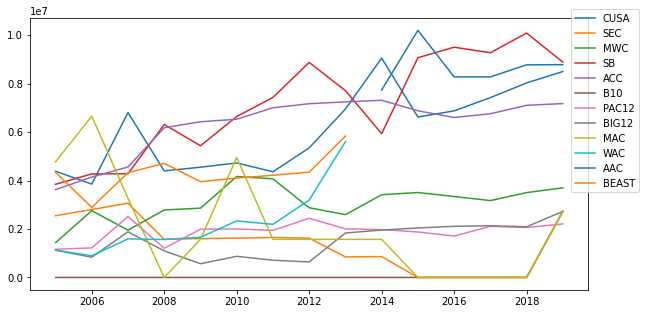

In [91]:
# Looking at student fees
# Lots of non power 5 conferences at the top of this list
plt.subplots(figsize=(10,5))
print('Conference USA:',cusa_trends['Student Fees'].max() - cusa_trends['Student Fees'].min())
print('Southeastern Conference:',sec_trends['Student Fees'].max() - sec_trends['Student Fees'].min())
print('Mountain West Conference:',mwc_trends['Student Fees'].max() - mwc_trends['Student Fees'].min())
print('Sunbelt Conference:',sb_trends['Student Fees'].max() - sb_trends['Student Fees'].min())
print('Atlantic Coast Conference:',acc_trends['Student Fees'].max() - acc_trends['Student Fees'].min())
print('Big 10 Conference:',b10_trends['Student Fees'].max() - b10_trends['Student Fees'].min())
print('Pac 12 Conference:',pac12_trends['Student Fees'].max() - pac12_trends['Student Fees'].min())
print('Big 12 Conference:',b12_trends['Student Fees'].max() - b12_trends['Student Fees'].min())
print('Mid-American Conference:',mac_trends['Student Fees'].max() - mac_trends['Student Fees'].min())
print('Western Athletic Conference:',wac_trends['Student Fees'].max() - wac_trends['Student Fees'].min())
print('American Athletic Conference:',aac_trends['Student Fees'].max() - aac_trends['Student Fees'].min())
print('Big East Conference:',beast_trends['Student Fees'].max() - beast_trends['Student Fees'].min())
plt.plot(cusa_trends['Student Fees'], label='CUSA')
plt.plot(sec_trends['Student Fees'], label='SEC')
plt.plot(mwc_trends['Student Fees'], label='MWC')
plt.plot(sb_trends['Student Fees'], label='SB')
plt.plot(acc_trends['Student Fees'], label='ACC')
plt.plot(b10_trends['Student Fees'], label='B10')
plt.plot(pac12_trends['Student Fees'], label='PAC12')
plt.plot(b12_trends['Student Fees'], label='BIG12')
plt.plot(mac_trends['Student Fees'], label='MAC')
plt.plot(wac_trends['Student Fees'], label='WAC')
plt.plot(aac_trends['Student Fees'], label='AAC')
plt.plot(beast_trends['Student Fees'], label='BEAST')
plt.legend(bbox_to_anchor=(1.1, 1.05));

Conference USA: 1.6512571956377444
Southeastern Conference: 2.7559058142716584
Mountain West Conference: 2.1914850841512923
Sunbelt Conference: 0.9235580258493803
Atlantic Coast Conference: 1.5691375220411103
Big 10 Conference: 1.0508332465724841
Pac 12 Conference: 1.7965227031380921
Big 12 Conference: 3.121954271281507
Mid-American Conference: 1.0577755127929738
Western Athletic Conference: 1.429148734680664
American Athletic Conference: 0.9083634936482419
Big East Conference: 1.3398181471328998


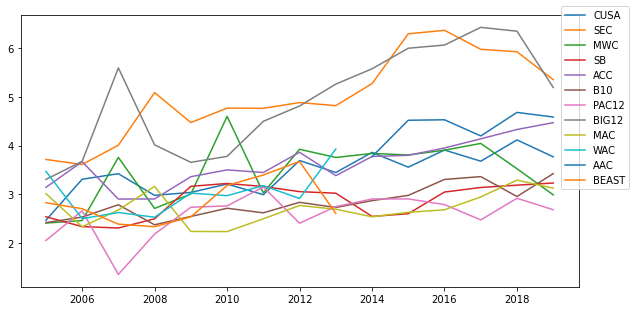

In [92]:
# Looking at ratio of athletic to academic spending
# SEC and Big 12 at the top
plt.subplots(figsize=(10,5))
print('Conference USA:',cusa_trends['Ratio of Athletic Spending vs. Academic Spending'].max() - cusa_trends['Ratio of Athletic Spending vs. Academic Spending'].min())
print('Southeastern Conference:',sec_trends['Ratio of Athletic Spending vs. Academic Spending'].max() - sec_trends['Ratio of Athletic Spending vs. Academic Spending'].min())
print('Mountain West Conference:',mwc_trends['Ratio of Athletic Spending vs. Academic Spending'].max() - mwc_trends['Ratio of Athletic Spending vs. Academic Spending'].min())
print('Sunbelt Conference:',sb_trends['Ratio of Athletic Spending vs. Academic Spending'].max() - sb_trends['Ratio of Athletic Spending vs. Academic Spending'].min())
print('Atlantic Coast Conference:',acc_trends['Ratio of Athletic Spending vs. Academic Spending'].max() - acc_trends['Ratio of Athletic Spending vs. Academic Spending'].min())
print('Big 10 Conference:',b10_trends['Ratio of Athletic Spending vs. Academic Spending'].max() - b10_trends['Ratio of Athletic Spending vs. Academic Spending'].min())
print('Pac 12 Conference:',pac12_trends['Ratio of Athletic Spending vs. Academic Spending'].max() - pac12_trends['Ratio of Athletic Spending vs. Academic Spending'].min())
print('Big 12 Conference:',b12_trends['Ratio of Athletic Spending vs. Academic Spending'].max() - b12_trends['Ratio of Athletic Spending vs. Academic Spending'].min())
print('Mid-American Conference:',mac_trends['Ratio of Athletic Spending vs. Academic Spending'].max() - mac_trends['Ratio of Athletic Spending vs. Academic Spending'].min())
print('Western Athletic Conference:',wac_trends['Ratio of Athletic Spending vs. Academic Spending'].max() - wac_trends['Ratio of Athletic Spending vs. Academic Spending'].min())
print('American Athletic Conference:',aac_trends['Ratio of Athletic Spending vs. Academic Spending'].max() - aac_trends['Ratio of Athletic Spending vs. Academic Spending'].min())
print('Big East Conference:',beast_trends['Ratio of Athletic Spending vs. Academic Spending'].max() - beast_trends['Ratio of Athletic Spending vs. Academic Spending'].min())
plt.plot(cusa_trends['Ratio of Athletic Spending vs. Academic Spending'], label='CUSA')
plt.plot(sec_trends['Ratio of Athletic Spending vs. Academic Spending'], label='SEC')
plt.plot(mwc_trends['Ratio of Athletic Spending vs. Academic Spending'], label='MWC')
plt.plot(sb_trends['Ratio of Athletic Spending vs. Academic Spending'], label='SB')
plt.plot(acc_trends['Ratio of Athletic Spending vs. Academic Spending'], label='ACC')
plt.plot(b10_trends['Ratio of Athletic Spending vs. Academic Spending'], label='B10')
plt.plot(pac12_trends['Ratio of Athletic Spending vs. Academic Spending'], label='PAC12')
plt.plot(b12_trends['Ratio of Athletic Spending vs. Academic Spending'], label='BIG12')
plt.plot(mac_trends['Ratio of Athletic Spending vs. Academic Spending'], label='MAC')
plt.plot(wac_trends['Ratio of Athletic Spending vs. Academic Spending'], label='WAC')
plt.plot(aac_trends['Ratio of Athletic Spending vs. Academic Spending'], label='AAC')
plt.plot(beast_trends['Ratio of Athletic Spending vs. Academic Spending'], label='BEAST')
plt.legend(bbox_to_anchor=(1.1, 1.05));

Conference USA: 6.5
Southeastern Conference: 4.0
Mountain West Conference: 6.5
Sunbelt Conference: 8.0
Atlantic Coast Conference: 5.5
Big 10 Conference: 5.0
Pac 12 Conference: 14.5
Big 12 Conference: 4.0
Mid-American Conference: 7.0
Western Athletic Conference: 5.5
American Athletic Conference: 1
Big East Conference: 7.5


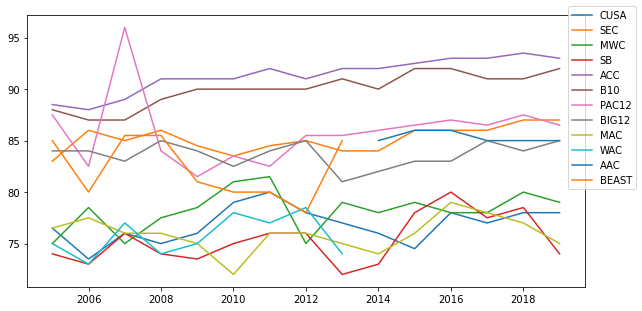

In [93]:
# Looking at full-time retention rate
plt.subplots(figsize=(10,5))
print('Conference USA:',cusa_trends['Full-time Retention Rate'].max() - cusa_trends['Full-time Retention Rate'].min())
print('Southeastern Conference:',sec_trends['Full-time Retention Rate'].max() - sec_trends['Full-time Retention Rate'].min())
print('Mountain West Conference:',mwc_trends['Full-time Retention Rate'].max() - mwc_trends['Full-time Retention Rate'].min())
print('Sunbelt Conference:',sb_trends['Full-time Retention Rate'].max() - sb_trends['Full-time Retention Rate'].min())
print('Atlantic Coast Conference:',acc_trends['Full-time Retention Rate'].max() - acc_trends['Full-time Retention Rate'].min())
print('Big 10 Conference:',b10_trends['Full-time Retention Rate'].max() - b10_trends['Full-time Retention Rate'].min())
print('Pac 12 Conference:',pac12_trends['Full-time Retention Rate'].max() - pac12_trends['Full-time Retention Rate'].min())
print('Big 12 Conference:',b12_trends['Full-time Retention Rate'].max() - b12_trends['Full-time Retention Rate'].min())
print('Mid-American Conference:',mac_trends['Full-time Retention Rate'].max() - mac_trends['Full-time Retention Rate'].min())
print('Western Athletic Conference:',wac_trends['Full-time Retention Rate'].max() - wac_trends['Full-time Retention Rate'].min())
print('American Athletic Conference:',aac_trends['Full-time Retention Rate'].max() - aac_trends['Full-time Retention Rate'].min())
print('Big East Conference:',beast_trends['Full-time Retention Rate'].max() - beast_trends['Full-time Retention Rate'].min())
plt.plot(cusa_trends['Full-time Retention Rate'], label='CUSA')
plt.plot(sec_trends['Full-time Retention Rate'], label='SEC')
plt.plot(mwc_trends['Full-time Retention Rate'], label='MWC')
plt.plot(sb_trends['Full-time Retention Rate'], label='SB')
plt.plot(acc_trends['Full-time Retention Rate'], label='ACC')
plt.plot(b10_trends['Full-time Retention Rate'], label='B10')
plt.plot(pac12_trends['Full-time Retention Rate'], label='PAC12')
plt.plot(b12_trends['Full-time Retention Rate'], label='BIG12')
plt.plot(mac_trends['Full-time Retention Rate'], label='MAC')
plt.plot(wac_trends['Full-time Retention Rate'], label='WAC')
plt.plot(aac_trends['Full-time Retention Rate'], label='AAC')
plt.plot(beast_trends['Full-time Retention Rate'], label='BEAST')
plt.legend(bbox_to_anchor=(1.1, 1.05));

Conference USA: 21.0
Southeastern Conference: 35.0
Mountain West Conference: 18.0
Sunbelt Conference: 27.5
Atlantic Coast Conference: 27.0
Big 10 Conference: 29.0
Pac 12 Conference: 28.0
Big 12 Conference: 21.0
Mid-American Conference: 19.5
Western Athletic Conference: 12.0
American Athletic Conference: 18.0
Big East Conference: 24.5


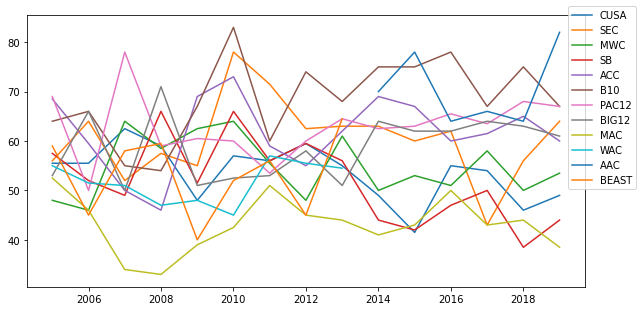

In [94]:
# Looking at part-time retention rate
# These are all over the place
plt.subplots(figsize=(10,5))
print('Conference USA:',cusa_trends['Part-time Retention Rate'].max() - cusa_trends['Part-time Retention Rate'].min())
print('Southeastern Conference:',sec_trends['Part-time Retention Rate'].max() - sec_trends['Part-time Retention Rate'].min())
print('Mountain West Conference:',mwc_trends['Part-time Retention Rate'].max() - mwc_trends['Part-time Retention Rate'].min())
print('Sunbelt Conference:',sb_trends['Part-time Retention Rate'].max() - sb_trends['Part-time Retention Rate'].min())
print('Atlantic Coast Conference:',acc_trends['Part-time Retention Rate'].max() - acc_trends['Part-time Retention Rate'].min())
print('Big 10 Conference:',b10_trends['Part-time Retention Rate'].max() - b10_trends['Part-time Retention Rate'].min())
print('Pac 12 Conference:',pac12_trends['Part-time Retention Rate'].max() - pac12_trends['Part-time Retention Rate'].min())
print('Big 12 Conference:',b12_trends['Part-time Retention Rate'].max() - b12_trends['Part-time Retention Rate'].min())
print('Mid-American Conference:',mac_trends['Part-time Retention Rate'].max() - mac_trends['Part-time Retention Rate'].min())
print('Western Athletic Conference:',wac_trends['Part-time Retention Rate'].max() - wac_trends['Part-time Retention Rate'].min())
print('American Athletic Conference:',aac_trends['Part-time Retention Rate'].max() - aac_trends['Part-time Retention Rate'].min())
print('Big East Conference:',beast_trends['Part-time Retention Rate'].max() - beast_trends['Part-time Retention Rate'].min())
plt.plot(cusa_trends['Part-time Retention Rate'], label='CUSA')
plt.plot(sec_trends['Part-time Retention Rate'], label='SEC')
plt.plot(mwc_trends['Part-time Retention Rate'], label='MWC')
plt.plot(sb_trends['Part-time Retention Rate'], label='SB')
plt.plot(acc_trends['Part-time Retention Rate'], label='ACC')
plt.plot(b10_trends['Part-time Retention Rate'], label='B10')
plt.plot(pac12_trends['Part-time Retention Rate'], label='PAC12')
plt.plot(b12_trends['Part-time Retention Rate'], label='BIG12')
plt.plot(mac_trends['Part-time Retention Rate'], label='MAC')
plt.plot(wac_trends['Part-time Retention Rate'], label='WAC')
plt.plot(aac_trends['Part-time Retention Rate'], label='AAC')
plt.plot(beast_trends['Part-time Retention Rate'], label='BEAST')
plt.legend(bbox_to_anchor=(1.1, 1.05));

Conference USA: 19017.0
Southeastern Conference: 21651.0
Mountain West Conference: 20338.0
Sunbelt Conference: 11692.0
Atlantic Coast Conference: 26384.5
Big 10 Conference: 25375.0
Pac 12 Conference: 32730.0
Big 12 Conference: 24644.0
Mid-American Conference: 27740.0
Western Athletic Conference: 14180.5
American Athletic Conference: 11298
Big East Conference: 18057.5


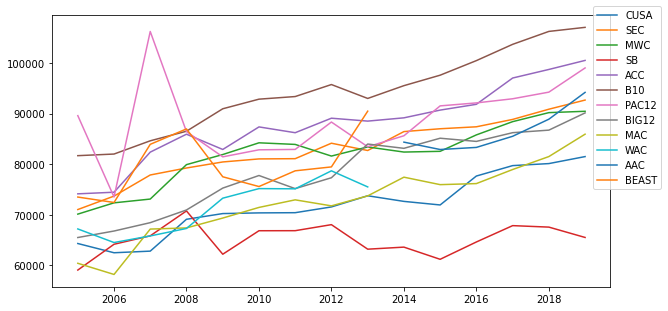

In [95]:
# Looking at average faculty salaries
plt.subplots(figsize=(10,5))
print('Conference USA:',cusa_trends['Average Faculty Salary'].max() - cusa_trends['Average Faculty Salary'].min())
print('Southeastern Conference:',sec_trends['Average Faculty Salary'].max() - sec_trends['Average Faculty Salary'].min())
print('Mountain West Conference:',mwc_trends['Average Faculty Salary'].max() - mwc_trends['Average Faculty Salary'].min())
print('Sunbelt Conference:',sb_trends['Average Faculty Salary'].max() - sb_trends['Average Faculty Salary'].min())
print('Atlantic Coast Conference:',acc_trends['Average Faculty Salary'].max() - acc_trends['Average Faculty Salary'].min())
print('Big 10 Conference:',b10_trends['Average Faculty Salary'].max() - b10_trends['Average Faculty Salary'].min())
print('Pac 12 Conference:',pac12_trends['Average Faculty Salary'].max() - pac12_trends['Average Faculty Salary'].min())
print('Big 12 Conference:',b12_trends['Average Faculty Salary'].max() - b12_trends['Average Faculty Salary'].min())
print('Mid-American Conference:',mac_trends['Average Faculty Salary'].max() - mac_trends['Average Faculty Salary'].min())
print('Western Athletic Conference:',wac_trends['Average Faculty Salary'].max() - wac_trends['Average Faculty Salary'].min())
print('American Athletic Conference:',aac_trends['Average Faculty Salary'].max() - aac_trends['Average Faculty Salary'].min())
print('Big East Conference:',beast_trends['Average Faculty Salary'].max() - beast_trends['Average Faculty Salary'].min())
plt.plot(cusa_trends['Average Faculty Salary'], label='CUSA')
plt.plot(sec_trends['Average Faculty Salary'], label='SEC')
plt.plot(mwc_trends['Average Faculty Salary'], label='MWC')
plt.plot(sb_trends['Average Faculty Salary'], label='SB')
plt.plot(acc_trends['Average Faculty Salary'], label='ACC')
plt.plot(b10_trends['Average Faculty Salary'], label='B10')
plt.plot(pac12_trends['Average Faculty Salary'], label='PAC12')
plt.plot(b12_trends['Average Faculty Salary'], label='BIG12')
plt.plot(mac_trends['Average Faculty Salary'], label='MAC')
plt.plot(wac_trends['Average Faculty Salary'], label='WAC')
plt.plot(aac_trends['Average Faculty Salary'], label='AAC')
plt.plot(beast_trends['Average Faculty Salary'], label='BEAST')
plt.legend(bbox_to_anchor=(1.1, 1.05));

Conference USA: 8639184.5
Southeastern Conference: 495763.0
Mountain West Conference: 11042670.5
Sunbelt Conference: 14162902.0
Atlantic Coast Conference: 3280709.5
Big 10 Conference: 3094797.0
Pac 12 Conference: 8450082.5
Big 12 Conference: 2919726.0
Mid-American Conference: 19080280.0
Western Athletic Conference: 4399722.5
American Athletic Conference: 11831079.0
Big East Conference: 7237428.5


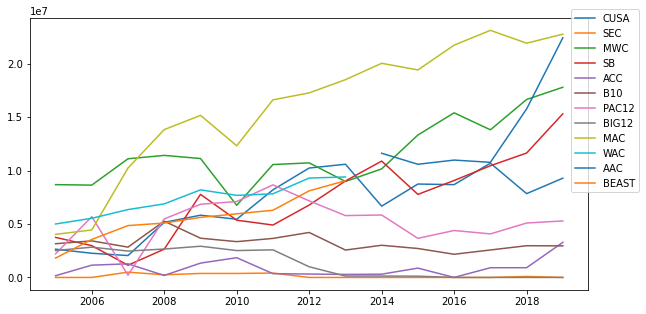

In [96]:
# Looking at institutional/government support
plt.subplots(figsize=(10,5))
print('Conference USA:',cusa_trends['Institutional/Government Support'].max() - cusa_trends['Institutional/Government Support'].min())
print('Southeastern Conference:',sec_trends['Institutional/Government Support'].max() - sec_trends['Institutional/Government Support'].min())
print('Mountain West Conference:',mwc_trends['Institutional/Government Support'].max() - mwc_trends['Institutional/Government Support'].min())
print('Sunbelt Conference:',sb_trends['Institutional/Government Support'].max() - sb_trends['Institutional/Government Support'].min())
print('Atlantic Coast Conference:',acc_trends['Institutional/Government Support'].max() - acc_trends['Institutional/Government Support'].min())
print('Big 10 Conference:',b10_trends['Institutional/Government Support'].max() - b10_trends['Institutional/Government Support'].min())
print('Pac 12 Conference:',pac12_trends['Institutional/Government Support'].max() - pac12_trends['Institutional/Government Support'].min())
print('Big 12 Conference:',b12_trends['Institutional/Government Support'].max() - b12_trends['Institutional/Government Support'].min())
print('Mid-American Conference:',mac_trends['Institutional/Government Support'].max() - mac_trends['Institutional/Government Support'].min())
print('Western Athletic Conference:',wac_trends['Institutional/Government Support'].max() - wac_trends['Institutional/Government Support'].min())
print('American Athletic Conference:',aac_trends['Institutional/Government Support'].max() - aac_trends['Institutional/Government Support'].min())
print('Big East Conference:',beast_trends['Institutional/Government Support'].max() - beast_trends['Institutional/Government Support'].min())
plt.plot(cusa_trends['Institutional/Government Support'], label='CUSA')
plt.plot(sec_trends['Institutional/Government Support'], label='SEC')
plt.plot(mwc_trends['Institutional/Government Support'], label='MWC')
plt.plot(sb_trends['Institutional/Government Support'], label='SB')
plt.plot(acc_trends['Institutional/Government Support'], label='ACC')
plt.plot(b10_trends['Institutional/Government Support'], label='B10')
plt.plot(pac12_trends['Institutional/Government Support'], label='PAC12')
plt.plot(b12_trends['Institutional/Government Support'], label='BIG12')
plt.plot(mac_trends['Institutional/Government Support'], label='MAC')
plt.plot(wac_trends['Institutional/Government Support'], label='WAC')
plt.plot(aac_trends['Institutional/Government Support'], label='AAC')
plt.plot(beast_trends['Institutional/Government Support'], label='BEAST')
plt.legend(bbox_to_anchor=(1.1, 1.05));

Conference USA: 105398515.0
Southeastern Conference: 644201287.0
Mountain West Conference: 174452187.5
Sunbelt Conference: 95551463.5
Atlantic Coast Conference: 695032575.5
Big 10 Conference: 2998955400.0
Pac 12 Conference: 639407915.5
Big 12 Conference: 538343257.5
Mid-American Conference: 154204550.5
Western Athletic Conference: 44739124.0
American Athletic Conference: 135221590.0
Big East Conference: 440423939.0


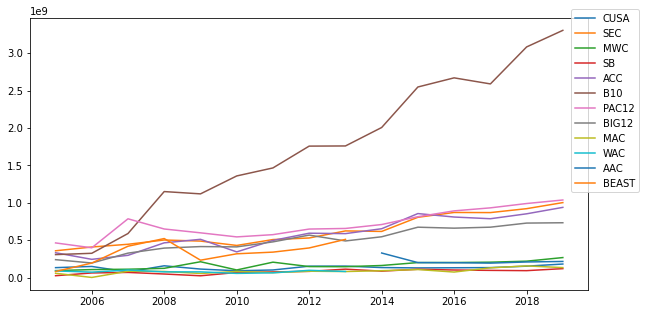

In [97]:
# Looking at endowments
plt.subplots(figsize=(10,5))
print('Conference USA:',cusa_trends['Endowment'].max() - cusa_trends['Endowment'].min())
print('Southeastern Conference:',sec_trends['Endowment'].max() - sec_trends['Endowment'].min())
print('Mountain West Conference:',mwc_trends['Endowment'].max() - mwc_trends['Endowment'].min())
print('Sunbelt Conference:',sb_trends['Endowment'].max() - sb_trends['Endowment'].min())
print('Atlantic Coast Conference:',acc_trends['Endowment'].max() - acc_trends['Endowment'].min())
print('Big 10 Conference:',b10_trends['Endowment'].max() - b10_trends['Endowment'].min())
print('Pac 12 Conference:',pac12_trends['Endowment'].max() - pac12_trends['Endowment'].min())
print('Big 12 Conference:',b12_trends['Endowment'].max() - b12_trends['Endowment'].min())
print('Mid-American Conference:',mac_trends['Endowment'].max() - mac_trends['Endowment'].min())
print('Western Athletic Conference:',wac_trends['Endowment'].max() - wac_trends['Endowment'].min())
print('American Athletic Conference:',aac_trends['Endowment'].max() - aac_trends['Endowment'].min())
print('Big East Conference:',beast_trends['Endowment'].max() - beast_trends['Endowment'].min())
plt.plot(cusa_trends['Endowment'], label='CUSA')
plt.plot(sec_trends['Endowment'], label='SEC')
plt.plot(mwc_trends['Endowment'], label='MWC')
plt.plot(sb_trends['Endowment'], label='SB')
plt.plot(acc_trends['Endowment'], label='ACC')
plt.plot(b10_trends['Endowment'], label='B10')
plt.plot(pac12_trends['Endowment'], label='PAC12')
plt.plot(b12_trends['Endowment'], label='BIG12')
plt.plot(mac_trends['Endowment'], label='MAC')
plt.plot(wac_trends['Endowment'], label='WAC')
plt.plot(aac_trends['Endowment'], label='AAC')
plt.plot(beast_trends['Endowment'], label='BEAST')
plt.legend(bbox_to_anchor=(1.1, 1.05));

In [98]:
b10.sort_values(by="Endowment")

UNITID                     Institution Name  Grand Total Revenue  \
Survey Year                                                                     
2005-01-01   151351       Indiana University-Bloomington             39526047   
2006-01-01   151351       Indiana University-Bloomington             44739096   
2007-01-01   151351       Indiana University-Bloomington             54839398   
2005-01-01   153658                   University of Iowa             66823699   
2006-01-01   153658                   University of Iowa             80203645   
...             ...                                  ...                  ...   
2018-01-01   174066  University of Minnesota-Twin Cities            122667963   
2019-01-01   171100            Michigan State University            122557963   
2019-01-01   174066  University of Minnesota-Twin Cities            110225936   
2018-01-01   240444      University of Wisconsin-Madison            151369153   
2019-01-01   240444      University of Wisconsin-Madison            143954553   

             Grand Total Expenses           NCAA Subdivision  \
Survey Year                                                    
2005-01-01               39451709  Football Bowl Subdivision   
2006-01-01               41527070  Football Bowl Subdivision   
2007-01-01               49209810  Football Bowl Subdivision   
2005-01-01               59138699  Football Bowl Subdivision   
2006-01-01               70904103  Football Bowl Subdivision   
...                           ...                        ...   
2018-01-01              111380179  Football Bowl Subdivision   
2019-01-01              122557963  Football Bowl Subdivision   
2019-01-01              107967114  Football Bowl Subdivision   
2018-01-01              140536659  Football Bowl Subdivision   
2019-01-01              137465083  Football Bowl Subdivision   

                 FBS Conference  Other Expenses    Medical  \
Survey Year                                                  
2005-01-01   Big Ten Conference       4438335.0  1203505.0   
2006-01-01   Big Ten Conference       4353426.0  1189772.0   
2007-01-01   Big Ten Conference       4535033.0  1088277.0   
2005-01-01   Big Ten Conference       9511225.0  1163501.0   
2006-01-01   Big Ten Conference       9779781.0   573779.0   
...                         ...             ...        ...   
2018-01-01   Big Ten Conference      11035928.0  1388942.0   
2019-01-01   Big Ten Conference      13496228.0  1848476.0   
2019-01-01   Big Ten Conference      11171992.0  1347705.0   
2018-01-01   Big Ten Conference      15139621.0  2369548.0   
2019-01-01   Big Ten Conference      15508419.0  2967255.0   

             Competition Guarantees (Expenses)  Recruiting  ...  \
Survey Year                                                 ...   
2005-01-01                           2456625.0    703774.0  ...   
2006-01-01                           2924982.0    822668.0  ...   
2007-01-01                           2852556.0    905270.0  ...   
2005-01-01                           5114298.0    762172.0  ...   
2006-01-01                           5438241.0    788375.0  ...   
...                                        ...         ...  ...   
2018-01-01                           2115222.0   2215207.0  ...   
2019-01-01                           3920447.0   1779251.0  ...   
2019-01-01                           3043781.0   2653888.0  ...   
2018-01-01                           3283944.0   1224327.0  ...   
2019-01-01                           3854600.0   1468846.0  ...   

             Part-time Retention Rate  Average Faculty Salary     Endowment  \
Survey Year                                                                   
2005-01-01                       64.0                   78723  1.135786e+08   
2006-01-01                       78.0                   80472  1.326497e+08   
2007-01-01                       57.0                   83356  1.445060e+08   
2005-01-01                       88.0               

# Modeling

In [99]:
# Trying to see if eliminating colleges without football impacts the model performance
df = df[df['NCAA Subdivision']!='No Football Subdivision']

[Based on NCES data](https://nces.ed.gov/programs/coe/indicator/ctr) (used in IPEDS variables), the average retention rate is 81% for all institutions including all acceptance rates. Thus, I will use this as the dividing point for creating a binned variable.

In [100]:
# Creating binned target variable based on median for logistic regression
# df_binned['WRR_Binned'] = np.where(df_binned['Weighted_Retention_Rate']>=df_binned['Weighted_Retention_Rate'].median(), 1.0, 0.0)
df['WRR_Binned'] = np.where(df['Weighted Retention Rate']>81.0, 1.0, 0.0)

In [101]:
# Class imbalance in favor of schools that have less than average retention rates.
df['WRR_Binned'].value_counts(normalize=True)

0.0    0.775852
1.0    0.224148
Name: WRR_Binned, dtype: float64

In [102]:
# Create the X (features) and y (target)
# Also dropping columns used in feature engineering.
X = df.drop(columns=['WRR_Binned', 'Weighted Retention Rate', 'Full-time Retention Rate', 'Part-time Retention Rate', 'No. Full-Time Students Retained', 
                 'No. Part-Time Students Retained', 'Total Enrollment', 'Full-time Enrollment',
                 'Part-time Enrollment', 'Total Student Athletes', 'UNITID', 'Institution Name'])
y = df['WRR_Binned']

# Split into 70% train, 30% test sets (less than 3/4 to combat overfitting)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.3)

In [103]:
cat_cols = ['NCAA Subdivision', 'FBS Conference', 'Survey Year']

In [104]:
num_cols = ['Grand Total Revenue', 'Grand Total Expenses', 'Other Expenses', 'Medical', 
            'Competition Guarantees (Expenses)', 'Recruiting', 'Game Expenses and Travel', 
            'Facilities and Equipment', 'Coaches Compensation', 'Support and Admin Compensation w/Severance',
            'Athletic Student Aid', 'Other Revenue', 'Corporate Sponsorship, Advertising, Licensing', 
            'Donor Contributions', 'Competition Guarantees (Revenues)', 
            'NCAA/Conference Distributions, Media Rights, and Post-Season Football', 'Ticket Sales', 
            'Institutional/Government Support', 'Student Fees', 
            'Total Institutional/Government Support and Student Fees', 'Total Academic Spending (University-Wide)', 
            'Total Football Spending', 'Total Football Coaching Salaries', 'Athletics Related Debt',
            'Annual Debt Service, Leases and Rental Fees on Athletic Facilities', 
            'Average Faculty Salary', 'Ratio of Athletic Spending vs. Academic Spending', 
            'Athletic Spending per Student Athlete', 'Academic Spending per FTE Student', 'Endowment']

In [105]:
# Categorical pipeline
cat_pipe = Pipeline([('ohe', OneHotEncoder())])

# Numeric pipeline
num_pipe = Pipeline([('min_max', MinMaxScaler())])

# Preprocessing pipeline, allow the untransformed columns to 'passthrough'
preprocessor = ColumnTransformer(transformers=[('categorical', cat_pipe, cat_cols),
                                               ('numerical', num_pipe, num_cols)],
                                 remainder='passthrough')

In [106]:
# Borrowed from Phase 3 project with Andrew
def evaluate(model, X_tr, y_tr, X_te, y_te, grid_search=False, save_fig_path=False):
    """
    Fit a model to train data and calculate classification metrics for train and test data.
    Plot the confusion matrix, ROC curve, and precision-recall curve for test data.

    ROC curve plotting code inspired by "Topic 25: Introduction to Logistic Regression 'ROC Curves and AUC'" from Flatiron School
    
    Inputs:
        model: sklearn-like model object
            The model to be fit.
        X_tr: array-like
            The input samples for train set.
        y_tr: array-like
            The target values for train set.
        X_te: array-like
            The input samples for test set.
        y_te: array-like
            The target values for test set.
        grid_search: boolean, default=False
            False: The model is not a grid search object.
            True: The model is a grid search object. The best parameters and the CV results will be displayed, and the fitted model will be returned.
        save_fig_path: boolean or str, default=False
            The path to save the visualizations
            False: don't save the visualizations
            str: save the visualizations to the path (also renames them to "Holdout Data")
        
    Outputs:
        model: sklearn-like model object
            The model chosen by the grid search based on the best CV score.
    """
    
    # fit the model
    model.fit(X_tr, y_tr)
    
    # predictions
    trn_preds = model.predict(X_tr)
    tst_preds = model.predict(X_te)
    tst_proba = model.predict_proba(X_te)[:,1]
    
    # roc auc calcs
    fpr, tpr, _ = roc_curve(y_te, tst_proba)
    roc_auc_text = f"AUC score: {auc(fpr, tpr):.3f}"

    # precision-recall curve calcs
    precision_c, recall_c, _ = precision_recall_curve(y_te, tst_proba)
    pr_auc_text = f"AUC score: {auc(recall_c, precision_c):.3f}"
    # predict all 1's
    dummy_preds = sum(y_te==1)/len(y_te)
    
    
    print("Training Metrics")
    # Accuracy
    print(f"Accuracy: {accuracy_score(y_tr, trn_preds):.3f}")
    # Precision
    print(f"Precision: {precision_score(y_tr, trn_preds):.3f}")
    # Recall
    print(f"Recall: {recall_score(y_tr, trn_preds):.3f}")
    # f1
    print(f"f1: {f1_score(y_tr, trn_preds):.3f}")
    print('-'*10)
    print("Testing Metrics")
    # Accuracy
    print(f"Accuracy: {accuracy_score(y_te, tst_preds):.3f}")
    # Precision
    print(f"Precision: {precision_score(y_te, tst_preds):.3f}")
    # Recall
    print(f"Recall: {recall_score(y_te, tst_preds):.3f}")
    # f1
    print(f"f1: {f1_score(y_te, tst_preds):.3f}")
    
    
    # create fig, axes
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8, 18))
    
    # confusion matrix
    plot_confusion_matrix(model, X_te, y_te, cmap='Blues', ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')
    ax1.grid(False)
    
    # roc curve
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_title('Receiver operating characteristic (ROC) Curve for Test Data')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.text(x=0.72, y=0.15, s=roc_auc_text, fontsize=14)
    ax2.legend(loc='lower right', fontsize=14)

    # precision-recall curve
    ax3.plot(recall_c, precision_c, color='darkorange', lw=2, label='Precision-Recall curve')
    ax3.plot([0, 1], [dummy_preds, dummy_preds], color='navy', lw=2, linestyle='--')
    ax3.set_title('Precision-Recall Curve for Test Data')
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.text(x=0.05, y=0.15, s=pr_auc_text, fontsize=14)
    ax3.legend(loc='lower left', fontsize=14)

    # save figs
    if save_fig_path:
        ax1.set_title('Confusion Matrix for Holdout Data')
        ax2.set_title('Receiver operating characteristic (ROC) Curve for Holdout Data')
        ax3.set_title('Precision-Recall Curve for Holdout Data')
        fig.savefig(save_fig_path)
    
    # display grid search results
    if grid_search:
        print(f"\nBest Parameters\n{model.best_params_}")
        results = DataFrame(model.cv_results_)
        display(results.sort_values('rank_test_f1'))
        return model

## Baseline Model

The predictor is set up to have 1.0 = schools with above average retention rates and 0.0 = below average retention rates.

True Positive: A school is identified as having above average retention rates and in fact does\
False Positive: A school is identified as having above average retention rates but in fact does not\
True Negative: A school is identified as having below average retention rates and in fact does\
False Negative: A school is identified as having below average retention rates but in fact does not

In this instance, I think false positives are more problematic than false negatives given that it is more of a problem to identify a school as above average when it is not. Thus, I will try and maximize precision scores throughout the modeling process.

In [107]:
baseline = DummyClassifier(strategy='stratified')

Training Metrics
Accuracy: 0.640
Precision: 0.211
Recall: 0.209
f1: 0.210
----------
Testing Metrics
Accuracy: 0.675
Precision: 0.225
Recall: 0.215
f1: 0.220


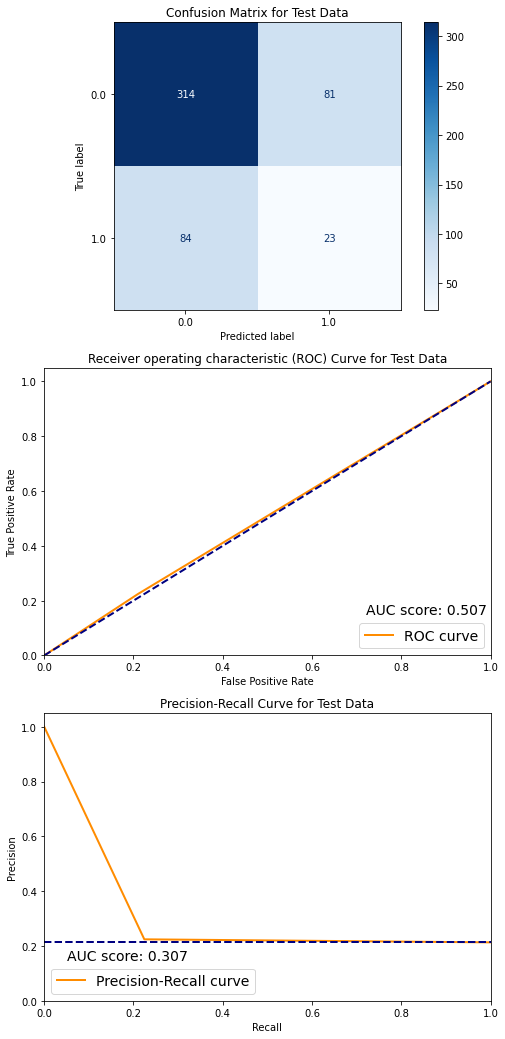

In [108]:
# Not great, but this is not unexpected for a baseline
evaluate(baseline, X_train, y_train, X_test, y_test)

## Logistic Regression

In [109]:
# Logistic regression pipeline
logr_pipe = Pipeline([('preprocessor', preprocessor),
                   ('logr', LogisticRegression(class_weight='balanced'))])

# Scoring metrics to be used throughout modeling process
scoring_metrics = ('recall', 'precision', 'f1')

# Cross validation
logr_cv = cross_validate(logr_pipe, X_train, y_train, scoring=scoring_metrics)

print(f"Mean Validation Recall: {np.mean(logr_cv['test_recall']):.3f}")
print(f"Mean Validation Precision: {np.mean(logr_cv['test_precision']):.3f}")
print(f"Mean Validation f1: {np.mean(logr_cv['test_f1']):.3f}")

Mean Validation Recall: 0.817
Mean Validation Precision: 0.711
Mean Validation f1: 0.760


Training Metrics
Accuracy: 0.899
Precision: 0.740
Recall: 0.862
f1: 0.797
----------
Testing Metrics
Accuracy: 0.876
Precision: 0.667
Recall: 0.841
f1: 0.744


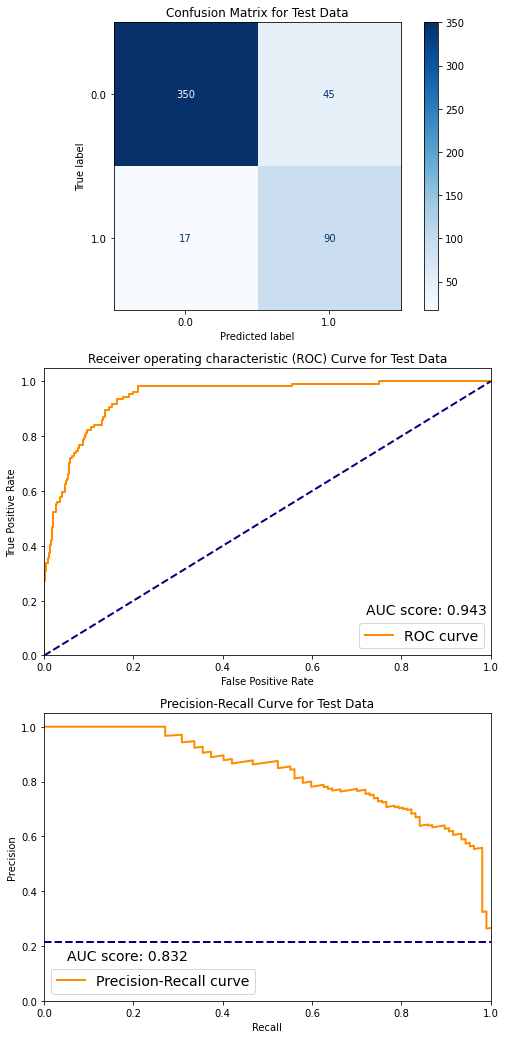

In [110]:
# Better than baseline. Recall higher than precision.
evaluate(logr_pipe, X_train, y_train, X_test, y_test)

## Decision Tree

In [111]:
# Decision tree pipeline
dt_pipe = Pipeline([('preprocessor', preprocessor),
                   ('dt', DecisionTreeClassifier())])

# Cross validation
dt_cv = cross_validate(dt_pipe, X_train, y_train, scoring=scoring_metrics)

print(f"Mean Validation Recall: {np.mean(dt_cv['test_recall']):.3f}")
print(f"Mean Validation Precision: {np.mean(dt_cv['test_precision']):.3f}")
print(f"Mean Validation f1: {np.mean(dt_cv['test_f1']):.3f}")

Mean Validation Recall: 0.776
Mean Validation Precision: 0.790
Mean Validation f1: 0.783


Training Metrics
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
f1: 1.000
----------
Testing Metrics
Accuracy: 0.908
Precision: 0.770
Recall: 0.813
f1: 0.791


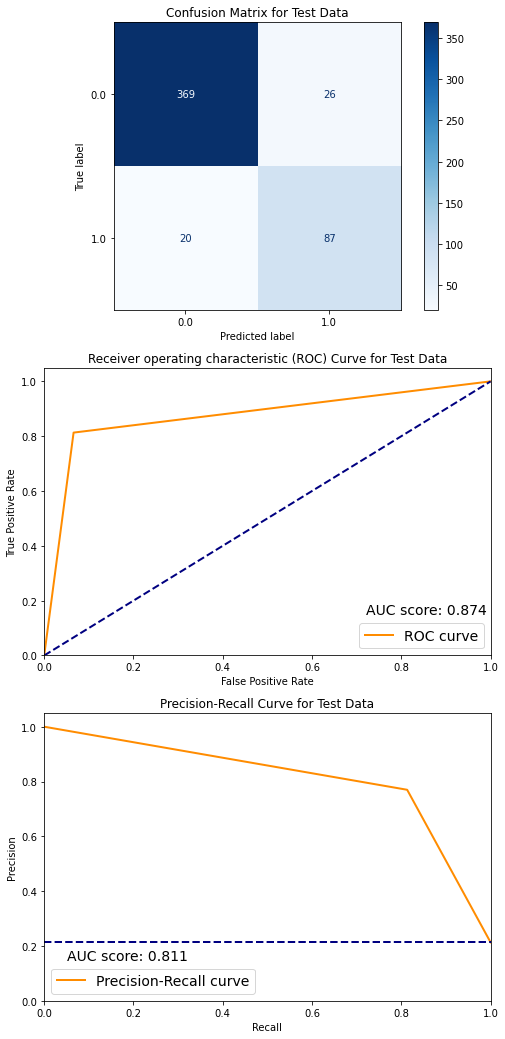

In [112]:
# Signs of overfitting, which is not surprising for a decision tree
evaluate(dt_pipe, X_train, y_train, X_test, y_test)

## Decision Tree Grid Search

In [113]:
# decision tree param grid
dt_grid = {'dt__max_depth': [3, 4, 5, 10],
          'dt__min_samples_leaf': [2, 5, 10, 20],
          'dt__criterion': ['gini', 'entropy'],
          'dt__class_weight': [None, 'balanced']}

dt_gs = GridSearchCV(estimator=dt_pipe, param_grid=dt_grid, scoring=scoring_metrics, refit='f1')

Training Metrics
Accuracy: 0.983
Precision: 0.992
Recall: 0.933
f1: 0.962
----------
Testing Metrics
Accuracy: 0.912
Precision: 0.806
Recall: 0.776
f1: 0.790

Best Parameters
{'dt__class_weight': None, 'dt__criterion': 'gini', 'dt__max_depth': 10, 'dt__min_samples_leaf': 2}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
12       0.021255      0.001158         0.005738        0.000188   
29       0.020229      0.001083         0.005698        0.000208   
28       0.020805      0.000752         0.005834        0.000270   
14       0.018772      0.002035         0.005665        0.000237   
13       0.019910      0.000427         0.005771        0.000351   
..            ...           ...              ...             ...   
27       0.017214      0.000644         0.005603        0.000232   
16       0.015679      0.001231         0.005920        0.000430   
17       0.014946      0.000281         0.005519        0.000119   
18       0.015556      0.001700         0.006287        0.001197   
19       0.014470      0.000404         0.005684        0.000445   

   param_dt__class_weight param_dt__criterion param_dt__max_depth  \
12                   None                gini                  10   
29                   None             entropy                  10   
28                   None             entropy                  10   
14                   None                gini                  10   
13                   None                gini                  10   
..                    ...                 ...                 ...   
27                   None             entropy                   5   
16                   None             entropy                   3   
17                   None             entropy                   3   
18                   None             entropy                   3   
19                   None             entropy                   3   

   param_dt__min_samples_leaf  \
12                          2   
29                          5   
28                          2   
14                         10   
13                          5   
..                        ...   
27                         20   
16                          2   
17                          5   
18                         10   
19                         20   

                                               params  split0_test_recall  \
12  {'dt__class_weight': None, 'dt__criterion': 'g...            0.740741   
29  {'dt__class_weight': None, 'dt__criterion': 'e...            0.740741   
28  {'dt__class_weight': None, 'dt__criterion': 'e...            0.740741   
14  {'dt__class_weight': None, 'dt__criterion': 'g...            0.629630   
13  {'dt__class_weight': None, 'dt__criterion': 'g...            0.685185   
..                                                ...                 ...   
27  {'dt__class_weight': None, 'dt__criterion': 'e...            0.740741   
16  {'dt__class_weight': None, 'dt__criterion': 'e...            0.796296   
17  {'dt__class_weight': None, 'dt__criterion': 'e...            0.796296   
18  {'dt__class_weight': None, 'dt__criterion': 'e...            0.796296   
19  {'dt__class_weight': None, 'dt__criterion': 'e...            0.796296   

    ...  std_test_precision  rank_test_precision  split0_test_f1  \
12  ...            0.019739                    6        0.792079   
29  ...            0.063012                    9        0.808081   
28  ...            0.064073                   11        0.808081   
14  ...            0.038199                   10        0.693878   
13  ...            0.036642                   13        0.732673   
..  ...                 ...                  ...             ...   
27  ...            0.066274                   36        0.634921   
16  ...            0.102650                   29        0.618705   
17  ...            0.102335                   31        0.618705   
18  ...            0.101229                   33        0.618705   
19  ...            0.095544                   35        0.618705   

    split1_test_f1  split2_test_f1  split3_test_f1  split4_test_f1  \
12        0.747475        0.800000        0.811321        0.841121   
29        0.723810        0.757282        0.875000        0.786325   
28       

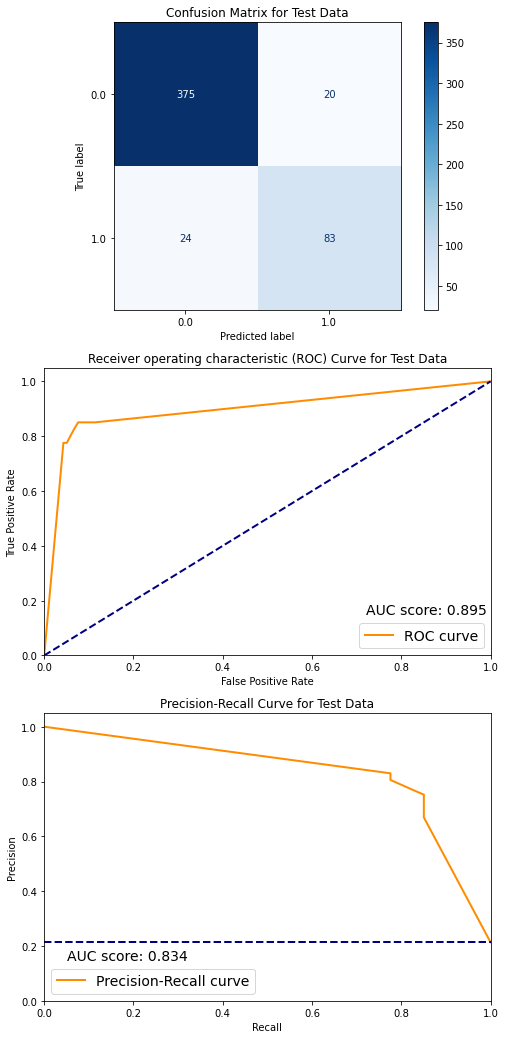

In [114]:
# Still overfit, but somewhat improved
dt_gs_model = evaluate(dt_gs, X_train, y_train, X_test, y_test, grid_search=True)

## Random Forest

In [115]:
# Decision tree pipeline
rf_pipe = Pipeline([('preprocessor', preprocessor),
                   ('rf', RandomForestClassifier())])

# Cross validation
rf_cv = cross_validate(rf_pipe, X_train, y_train, scoring=scoring_metrics)

print(f"Mean Validation Recall: {np.mean(rf_cv['test_recall']):.3f}")
print(f"Mean Validation Precision: {np.mean(rf_cv['test_precision']):.3f}")
print(f"Mean Validation f1: {np.mean(rf_cv['test_f1']):.3f}")

Mean Validation Recall: 0.761
Mean Validation Precision: 0.894
Mean Validation f1: 0.820


Training Metrics
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
f1: 1.000
----------
Testing Metrics
Accuracy: 0.936
Precision: 0.903
Recall: 0.785
f1: 0.840


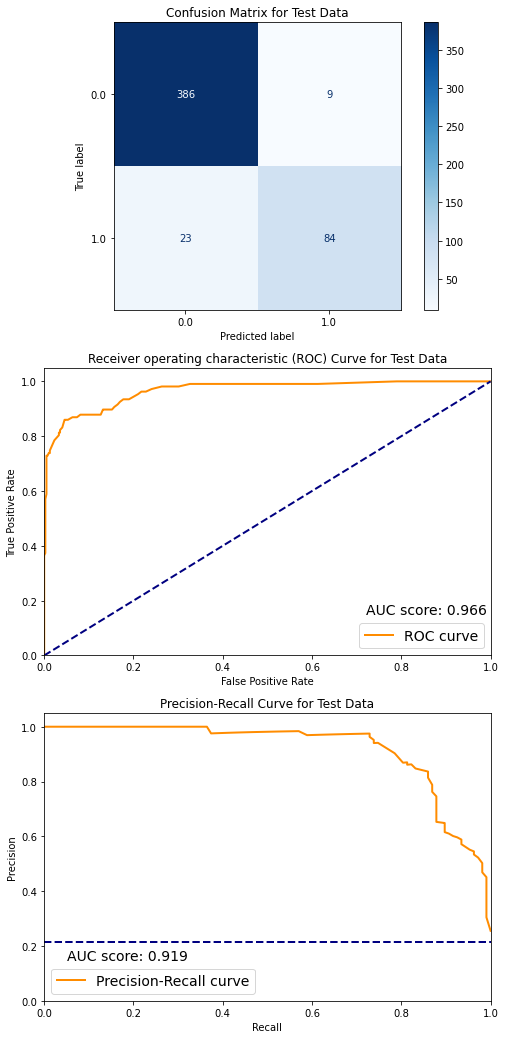

In [116]:
evaluate(rf_pipe, X_train, y_train, X_test, y_test)

In [117]:
rf_grid = {
    'rf__min_samples_split': [3, 5, 10], 
    'rf__n_estimators' : [100, 300],
    'rf__max_depth': [3, 5, 15, 25],
    'rf__max_features': [3, 5, 10, 20]
}

rf_gs = GridSearchCV(estimator=rf_pipe, param_grid=rf_grid, scoring=scoring_metrics, refit='f1')

Training Metrics
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
f1: 1.000
----------
Testing Metrics
Accuracy: 0.928
Precision: 0.851
Recall: 0.804
f1: 0.827

Best Parameters
{'rf__max_depth': 25, 'rf__max_features': 20, 'rf__min_samples_split': 3, 'rf__n_estimators': 100}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
90       0.366467      0.009061         0.013068        0.000236   
60       0.277545      0.016659         0.015211        0.001179   
84       0.239273      0.002495         0.013363        0.000205   
61       0.742723      0.043527         0.030514        0.001172   
85       0.688260      0.011225         0.028820        0.000960   
..            ...           ...              ...             ...   
1        0.338901      0.011949         0.026064        0.000495   
3        0.335804      0.007777         0.025861        0.000381   
2        0.114539      0.000869         0.012439        0.000091   
8        0.127084      0.000853         0.012515        0.000160   
0        0.118615      0.005932         0.012658        0.000151   

   param_rf__max_depth param_rf__max_features param_rf__min_samples_split  \
90                  25                     20                           3   
60                  15                     10                           3   
84                  25                     10                           3   
61                  15                     10                           3   
85                  25                     10                           3   
..                 ...                    ...                         ...   
1                    3                      3                           3   
3                    3                      3                           5   
2                    3                      3                           5   
8                    3                      5                           5   
0                    3                      3                           3   

   param_rf__n_estimators                                             params  \
90                    100  {'rf__max_depth': 25, 'rf__max_features': 20, ...   
60                    100  {'rf__max_depth': 15, 'rf__max_features': 10, ...   
84                    100  {'rf__max_depth': 25, 'rf__max_features': 10, ...   
61                    300  {'rf__max_depth': 15, 'rf__max_features': 10, ...   
85                    300  {'rf__max_depth': 25, 'rf__max_features': 10, ...   
..                    ...                                                ...   
1                     300  {'rf__max_depth': 3, 'rf__max_features': 3, 'r...   
3                     300  {'rf__max_depth': 3, 'rf__max_features': 3, 'r...   
2                     100  {'rf__max_depth': 3, 'rf__max_features': 3, 'r...   
8                     100  {'rf__max_depth': 3, 'rf__max_features': 5, 'r...   
0                     100  {'rf__max_depth': 3, 'rf__max_features': 3, 'r...   

    split0_test_recall  ...  std_test_precision  rank_test_precision  \
90            0.833333  ...            0.032897                    8   
60            0.833333  ...            0.036009                    4   
84            0.814815  ...            0.030883                    7   
61            0.814815  ...            0.030507                    3   
85            0.814815  ...            0.037359                    2   
..                 ...  ...                 ...                  ...   
1             0.629630  ...            0.042404                   89   
3             0.648148  ...            0.031944                   94   
2             0.611111  ...            0.026101                   95   
8             0.629630  ...            0.040806                   88   
0             0.666667  ...            0.028225                   96   

    split0_test_f1  split1_test_f1  split2_test_f1  split3_test_f1  \
90        0.882353        0.755556        0.843137        0.841121   
60        0.891089        0.774194        0.828283        0.830189   
84        0.871287        0.782609        0.831683        0.838095   
61        0.862745        0.777778        0.831683        0.838095   
85        0.871287        0.777778        0.811881        0.849057   
..             .

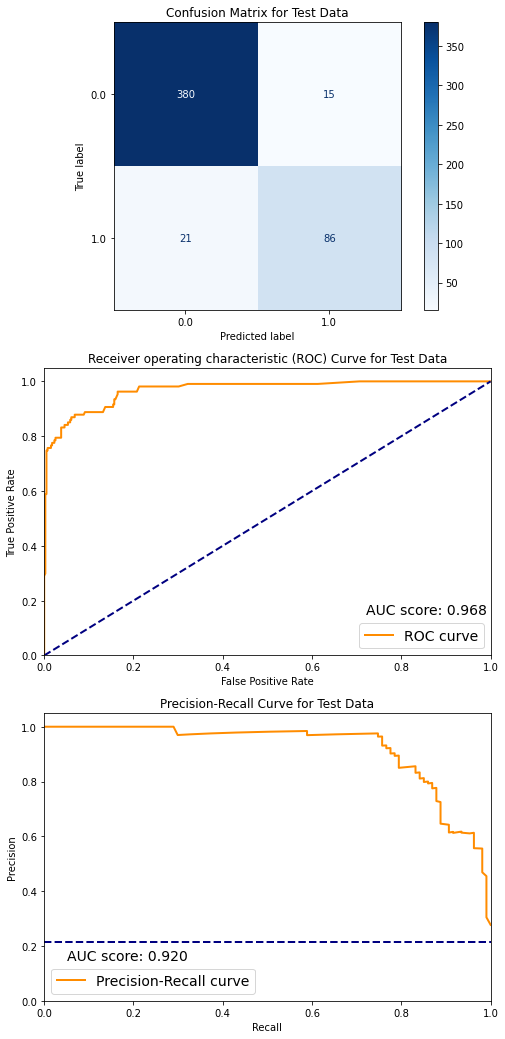

In [118]:
rf_gs_model = evaluate(rf_gs, X_train, y_train, X_test, y_test, grid_search=True)

## Gradient Boost

In [119]:
# gradient boosting pipeline
gb_pipe = Pipeline([('preprocessor', preprocessor),
                   ('gb', GradientBoostingClassifier(learning_rate=0.01,
                                                     max_depth=10,
                                                     min_samples_leaf=10,
                                                     n_estimators=1000))])

# cross validation
gb_cv = cross_validate(gb_pipe, X_train, y_train, scoring=scoring_metrics)

print(f"Mean Validation Recall: {np.mean(gb_cv['test_recall']):.3f}")
print(f"Mean Validation Precision: {np.mean(gb_cv['test_precision']):.3f}")
print(f"Mean Validation f1: {np.mean(gb_cv['test_f1']):.3f}")

Mean Validation Recall: 0.810
Mean Validation Precision: 0.897
Mean Validation f1: 0.850


Training Metrics
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
f1: 1.000
----------
Testing Metrics
Accuracy: 0.936
Precision: 0.871
Recall: 0.822
f1: 0.846


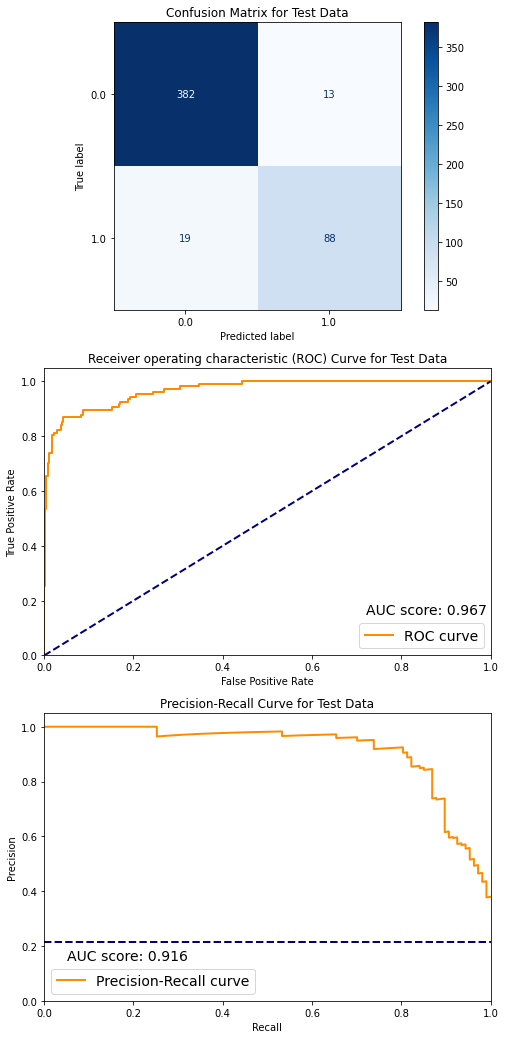

In [120]:
# Also overfit but better than dt
evaluate(gb_pipe, X_train, y_train, X_test, y_test)

## Stacked Models

In [121]:
# Stacked model (Decision Tree GS and Logistic Regression)
stacked_model1 = VotingClassifier(estimators=[('dt', dt_gs_model.best_estimator_),
                                          ('logr', logr_pipe)],
                              voting='soft')

In [122]:
s1_cv = cross_validate(stacked_model1, X_train, y_train, scoring=scoring_metrics)

print(f"Mean Validation Recall: {np.mean(s1_cv['test_recall']):.3f}")
print(f"Mean Validation Precision: {np.mean(s1_cv['test_precision']):.3f}")
print(f"Mean Validation f1: {np.mean(s1_cv['test_f1']):.3f}")

Mean Validation Recall: 0.787
Mean Validation Precision: 0.819
Mean Validation f1: 0.802


Training Metrics
Accuracy: 0.982
Precision: 0.970
Recall: 0.951
f1: 0.960
----------
Testing Metrics
Accuracy: 0.916
Precision: 0.788
Recall: 0.832
f1: 0.809


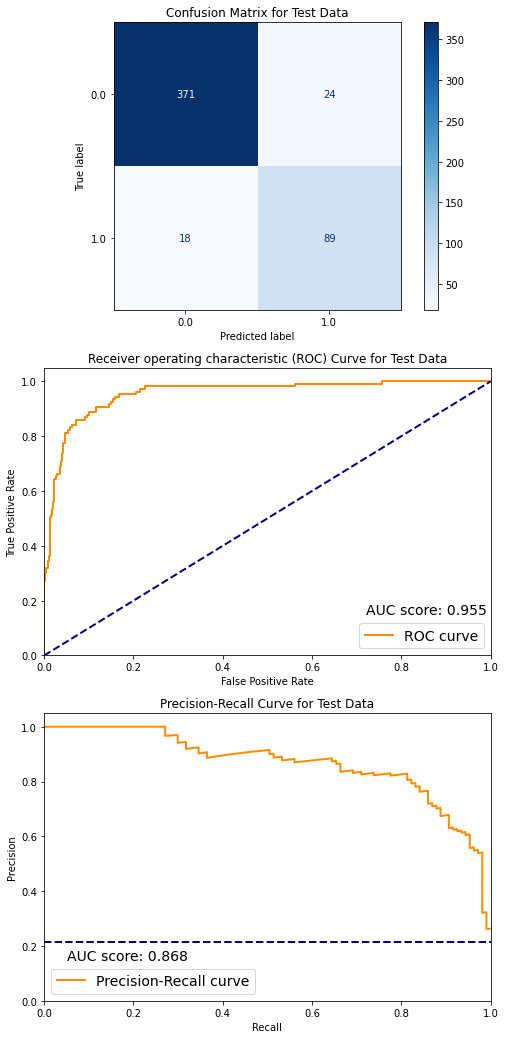

In [123]:
# Overfit seems to improve
evaluate(stacked_model1, X_train, y_train, X_test, y_test)

In [124]:
# stacked model (Decision Tree GS and Gradient Boost)
stacked_model2 = VotingClassifier(estimators=[('dt', dt_gs_model.best_estimator_),
                                          ('gb', gb_pipe)],
                              voting='soft')

In [125]:
s2_cv = cross_validate(stacked_model2, X_train, y_train, scoring=scoring_metrics)

print(f"Mean Validation Recall: {np.mean(s2_cv['test_recall']):.3f}")
print(f"Mean Validation Precision: {np.mean(s2_cv['test_precision']):.3f}")
print(f"Mean Validation f1: {np.mean(s2_cv['test_f1']):.3f}")

Mean Validation Recall: 0.787
Mean Validation Precision: 0.825
Mean Validation f1: 0.804


Training Metrics
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
f1: 1.000
----------
Testing Metrics
Accuracy: 0.916
Precision: 0.783
Recall: 0.841
f1: 0.811


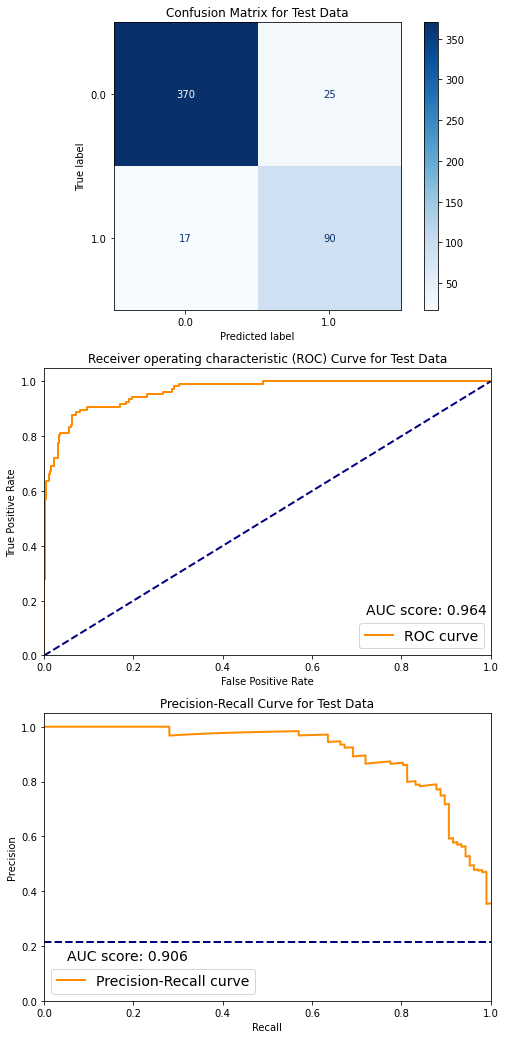

In [126]:
# Overfit
evaluate(stacked_model2, X_train, y_train, X_test, y_test)

In [127]:
# Stacked model (DTGS, gradient boost, and logistic regression)
stacked_model3 = VotingClassifier(estimators=[('dt', dt_gs_model.best_estimator_),
                                          ('gb', gb_pipe),
                                             ('logr', logr_pipe)],
                              voting='soft')

Training Metrics
Accuracy: 0.997
Precision: 1.000
Recall: 0.985
f1: 0.992
----------
Testing Metrics
Accuracy: 0.926
Precision: 0.812
Recall: 0.850
f1: 0.831


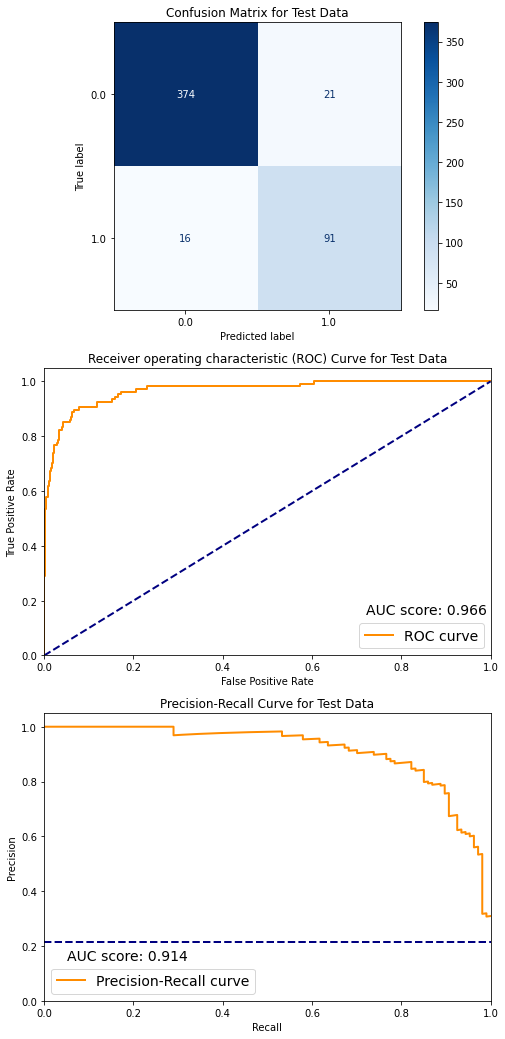

In [128]:
# Still overfit but the best overall performance?
evaluate(stacked_model3, X_train, y_train, X_test, y_test)

In [129]:
# Stacked model (random forest and logistic regression)
stacked_model4 = VotingClassifier(estimators=[('rf', rf_gs_model.best_estimator_),
                                             ('logr', logr_pipe)],
                              voting='soft')

Training Metrics
Accuracy: 0.974
Precision: 0.925
Recall: 0.966
f1: 0.945
----------
Testing Metrics
Accuracy: 0.908
Precision: 0.756
Recall: 0.841
f1: 0.796


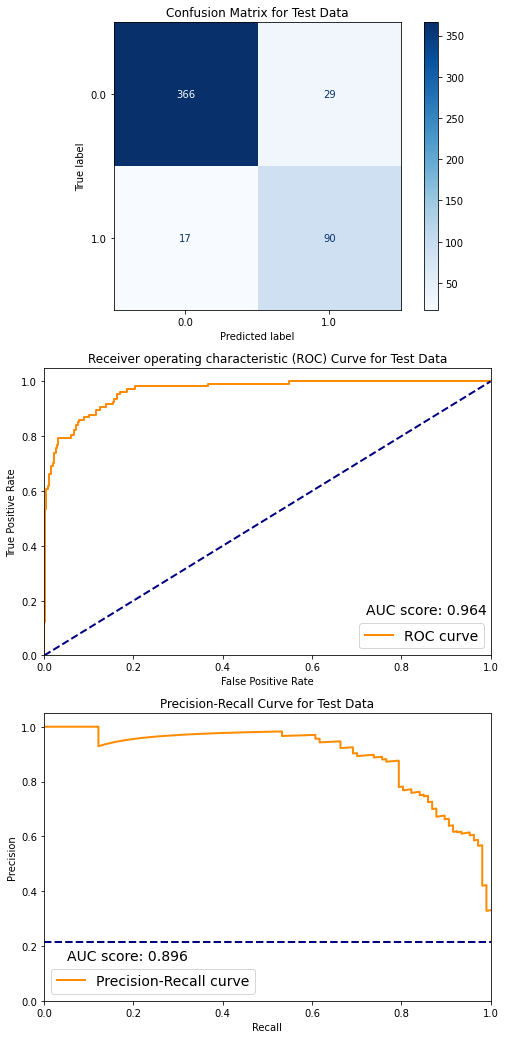

In [130]:
# Still overfit but the best overall performance?
evaluate(stacked_model4, X_train, y_train, X_test, y_test)

In [131]:
# Stacked model (random forest and DTGS)
stacked_model5 = VotingClassifier(estimators=[('rf', rf_gs_model.best_estimator_),
                                             ('dt', dt_gs_model.best_estimator_)],
                              voting='soft')

Training Metrics
Accuracy: 0.997
Precision: 1.000
Recall: 0.985
f1: 0.992
----------
Testing Metrics
Accuracy: 0.914
Precision: 0.802
Recall: 0.794
f1: 0.798


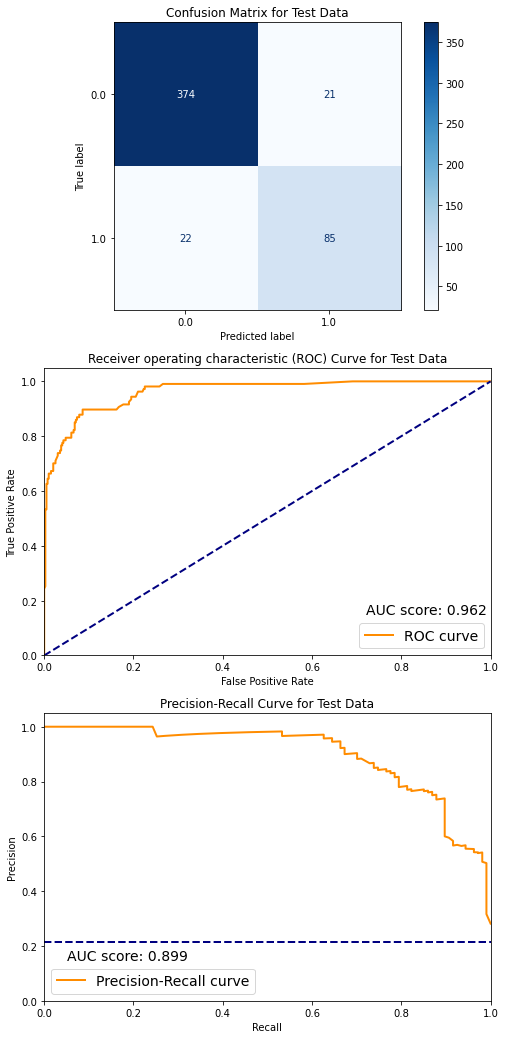

In [132]:
# Still overfit but the best overall performance?
evaluate(stacked_model5, X_train, y_train, X_test, y_test)

In [133]:
# Stacked model (random forest and gradient boost)
stacked_model6 = VotingClassifier(estimators=[('rf', rf_gs_model.best_estimator_),
                                             ('gb', gb_pipe)],
                              voting='soft')

Training Metrics
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
f1: 1.000
----------
Testing Metrics
Accuracy: 0.938
Precision: 0.865
Recall: 0.841
f1: 0.853


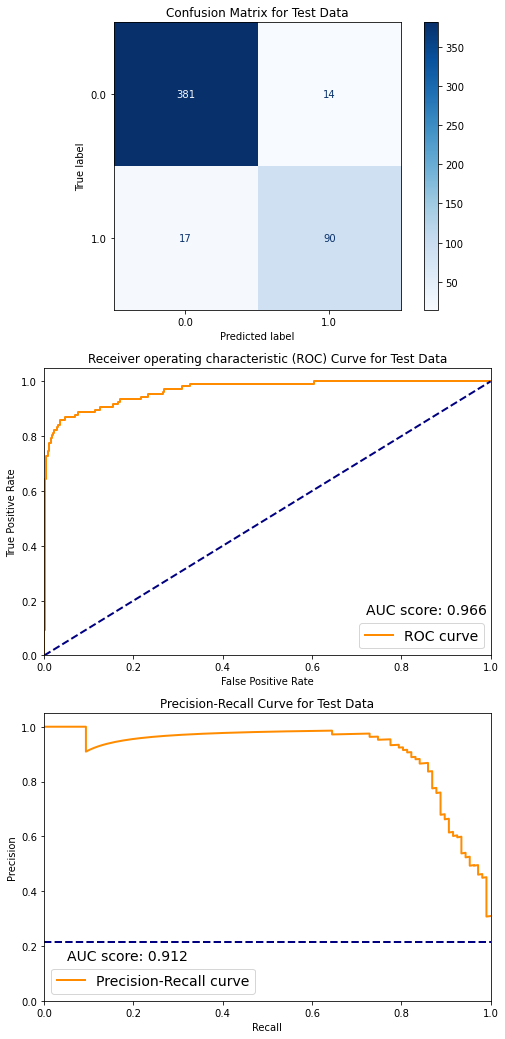

In [134]:
# Still overfit but the best overall performance?
evaluate(stacked_model6, X_train, y_train, X_test, y_test)

In [135]:
# Stacked model (random forest and gradient boost)
stacked_model7 = VotingClassifier(estimators=[('rf', rf_gs_model.best_estimator_),
                                             ('gb', gb_pipe),
                                             ('logr', logr_pipe),
                                             ('dt', dt_gs_model.best_estimator_)],
                              voting='soft')

Training Metrics
Accuracy: 0.997
Precision: 1.000
Recall: 0.989
f1: 0.994
----------
Testing Metrics
Accuracy: 0.920
Precision: 0.807
Recall: 0.822
f1: 0.815


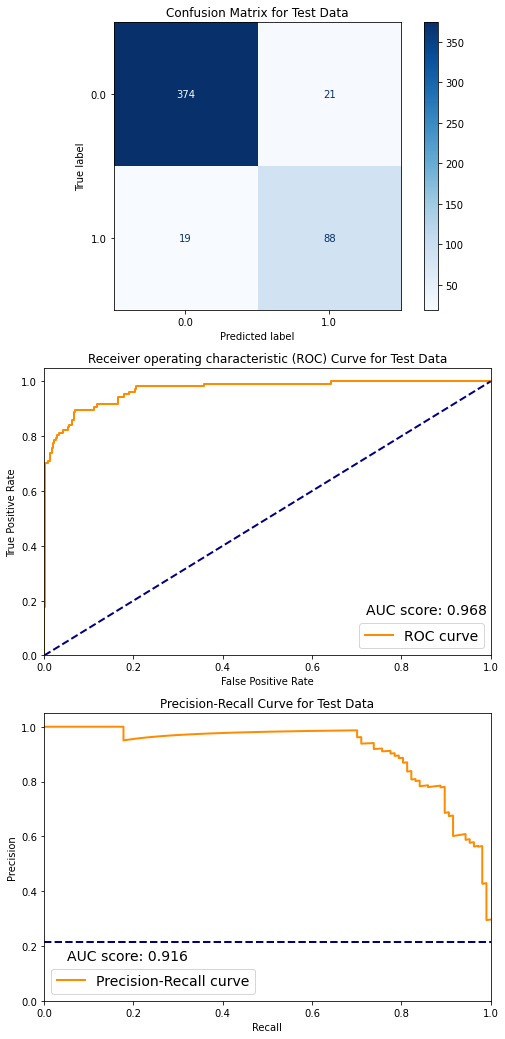

In [136]:
# Still overfit but the best overall performance?
evaluate(stacked_model7, X_train, y_train, X_test, y_test)

## Feature Importance

In [137]:
# array of feature importance values for the decision tree
# feature_importance_values = stacked_model4.estimators_[0]['rf'].feature_importances_
feature_importance_values = rf_gs_model.best_estimator_[1].feature_importances_

In [138]:
# OHE feature names
ohe_cols = rf_gs_model.best_estimator_['preprocessor'].transformers_[0][1]['ohe'].get_feature_names()

In [139]:
# features not transformed by the Column Transformer were passed through
remainder_cols = [c for c in X_train.columns if c not in [*cat_cols, *num_cols]]

In [140]:
# preprocessor features are in order of the steps, followed by any 'passthrough' features in the remainder
feature_cols = [*ohe_cols, *num_cols, *remainder_cols]

In [141]:
# create DataFrame with feature names and importance
feature_df = pd.DataFrame.from_dict(dict(zip(feature_cols, feature_importance_values)),
                                    orient='index',
                                    columns=['feature importance'])

In [142]:
# sort them!
feature_df.sort_values('feature importance', ascending=False).head(10)

feature importance
Total Academic Spending (University-Wide)                     0.131256
Average Faculty Salary                                        0.080096
NCAA/Conference Distributions, Media Rights, an...            0.073130
Student Fees                                                  0.065020
Grand Total Revenue                                           0.053766
Ticket Sales                                                  0.045407
Grand Total Expenses                                          0.042096
Endowment                                                     0.039906
Total Football Spending                                       0.039225
Institutional/Government Support                              0.030468

In [143]:
# array of logistic regression coefficients
logr_coef = stacked_model4.estimators_[1]['logr'].coef_

In [144]:
# create DataFrame with feature names and coefficients
coef_df = pd.DataFrame.from_dict(dict(zip(X_train.columns, logr_coef.reshape(-1))),
                                    orient='index',
                                    columns=['coefficient'])

# sort them!
coef_df.sort_values('coefficient', ascending=False)

coefficient
NCAA Subdivision                                       1.852311
Medical                                                1.834833
Donor Contributions                                    1.313178
Corporate Sponsorship, Advertising, Licensing          1.147133
Ratio of Athletic Spending vs. Academic Spending       0.643901
NCAA/Conference Distributions, Media Rights, an...     0.616127
Athletic Spending per Student Athlete                  0.546399
Competition Guarantees (Revenues)                      0.544766
FBS Conference                                         0.499851
Total Institutional/Government Support and Stud...     0.467473
Academic Spending per FTE Student                      0.425387
Support and Admin Compensation w/Severance             0.424080
Student Fees                                           0.294433
Facilities and Equipment                               0.194695
Grand Total Revenue                                    0.194695
Other Revenue                                          0.079042
Ticket Sales                                           0.058429
Game Expenses and Travel                              -0.002420
Grand Total Expenses                                  -0.054822
Institutional/Government Support                      -0.061970
Survey Year                                           -0.193993
Total Football Spending                               -0.213060
Total Academic Spending (University-Wide)             -0.278387
Coaches Compensation                                  -0.429254
Other Expenses                                        -0.483382
Total Football Coaching Salaries                      -0.492220
Endowment                                             -0.608745
Athletics Related Debt                                -0.644607
Recruiting                                            -1.011816
Annual Debt Service, Leases and Rental Fees on ...    -1.015954
Average Faculty Salary                                -1.125893
Competition Guarantees (Expenses)                     -1.296160
Athletic Student Aid                                  -1.606254

In [145]:
np.exp(coef_df.loc['Medical', 'coefficient'])

6.2640852895720345

In [146]:
np.exp(coef_df.loc['Average Faculty Salary', 'coefficient'])

0.3243628374257126

In [147]:
# predict the DD class threatened status
df_preds = pd.DataFrame(rf_gs_model.predict(df), index=df.index, columns=['prediction'])

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


In [148]:
# create DataFrame to inspect predictions
df_preds = pd.concat([df.loc[df.index, ['UNITID', 'Institution Name', 'Survey Year', 'FBS Conference', 
                                        'Ratio of Athletic Spending vs. Academic Spending', 'Grand Total Revenue',
                                       'Grand Total Expenses', 'Student Fees', 
                                        'Total Academic Spending (University-Wide)', 'Total Football Spending',
                                       'Average Faculty Salary', 'Endowment', 'Academic Spending per FTE Student',
                                       'Athletic Spending per Student Athlete', 'Weighted Retention Rate']], df_preds], axis=1)

In [149]:
# how many are predicted to be threatened
df_preds['prediction'].value_counts(normalize=True)

0.0    0.779438
1.0    0.220562
Name: prediction, dtype: float64

In [150]:
# Splitting the prediction df into above and below average retention rates to get more specific school/conference info
above_average_preds = df_preds[df_preds['prediction']==1.0]
below_average_preds = df_preds[df_preds['prediction']==0.0]

In [151]:
above_average_preds['FBS Conference'].value_counts()

N/A                             69
Big Ten Conference              65
Atlantic Coast Conference       65
Southeastern Conference         50
Pacific-12 Conference           32
Big 12 Conference               28
Conference USA                  16
American Athletic Conference    15
Mountain West Conference        15
Big East Conference              9
Western Athletic Conference      3
Mid-American Conference          1
Sun Belt Conference              1
Name: FBS Conference, dtype: int64

In [152]:
below_average_preds['FBS Conference'].value_counts()

N/A                             757
Conference USA                  116
Sun Belt Conference              74
Mountain West Conference         73
Mid-American Conference          63
Western Athletic Conference      49
Southeastern Conference          44
Big 12 Conference                43
Pacific-12 Conference            40
American Athletic Conference     15
Big East Conference              14
Atlantic Coast Conference         9
Big Ten Conference                7
Name: FBS Conference, dtype: int64

In [153]:
above_average_preds['Ratio of Athletic Spending vs. Academic Spending'].sort_values(ascending=False)

2191    12.897987
2025    11.847377
1859    11.204283
2252    10.471808
1693     9.951319
          ...    
1269     0.649682
1435     0.645749
771      0.584179
439      0.583009
605      0.572283
Name: Ratio of Athletic Spending vs. Academic Spending, Length: 369, dtype: float64

In [154]:
below_average_preds['Ratio of Athletic Spending vs. Academic Spending'].sort_values(ascending=False)

210     129.327452
229     104.930430
255     104.129511
44       36.785871
264      21.276160
           ...    
1551      0.646277
412       0.643064
2215      0.610079
334       0.608783
600       0.570016
Name: Ratio of Athletic Spending vs. Academic Spending, Length: 1304, dtype: float64

In [155]:
below_average_preds.sort_values(by='Ratio of Athletic Spending vs. Academic Spending', ascending=False).head(10)

UNITID                                   Institution Name Survey Year  \
210   175856                           Jackson State University  2006-01-01   
229   232937                           Norfolk State University  2006-01-01   
255   221838                         Tennessee State University  2006-01-01   
44    175856                           Jackson State University  2005-01-01   
264   228796                 The University of Texas at El Paso  2006-01-01   
63    232937                           Norfolk State University  2005-01-01   
225   163453                            Morgan State University  2006-01-01   
271   106412               University of Arkansas at Pine Bluff  2006-01-01   
2374  159391  Louisiana State University and Agricultural & ...  2019-01-01   
93    229115                              Texas Tech University  2005-01-01   

               FBS Conference  \
210                       N/A   
229                       N/A   
255                       N/A   
44                        N/A   
264            Conference USA   
63                        N/A   
225                       N/A   
271                       N/A   
2374  Southeastern Conference   
93          Big 12 Conference   

      Ratio of Athletic Spending vs. Academic Spending  Grand Total Revenue  \
210                                         129.327452              6183042   
229                                         104.930430              7613928   
255                                         104.129511              8758809   
44                                           36.785871              5559410   
264                                          21.276160             20831731   
63                                           17.586214              7014188   
225                                          15.979218              7166041   
271                                          15.098576              5282874   
2374                                          9.749953            160460476   
93                                            9.475325             53337766   

      Grand Total Expenses  Student Fees  \
210                6183042     2328550.0   
229                6650221     5897446.0   
255                8758808     1441472.0   
44                 5559410     2166545.0   
264               20683906     2180643.0   
63                 6284754     6302580.0   
225                7166041     4767837.0   
271                5131380     1206533.0   
2374             155591056     2725978.0   
93                53337766     2669242.0   

      Total Academic Spending (University-Wide)  Total Football Spending  \
210                                 154160785.0                1276402.0   
229                                 101023619.0                1971645.0   
255                                 136013263.0                2761736.0   
44                                  138714762.0                1132574.0   
264                                 211295309.0                7624452.0   
63                                   96906352.0                1622134.0   
225                                 128873245.0                1674141.0   
271                                  54188544.0                1415652.0   
2374                                923852059.0               35319160.0   
93                                  359510437.0               17848380.0   

      Average Faculty Salary    Endowment  Academic Spending per FTE Student  \
210                    49353   10250314.0                           23904.60   
229                    57802    6088777.0                           21125.81   
255                    55370   20698900.0                           21028.64   
44                     49070    7845966.0                           21589.85   
264                    60496  132056362.0                           17675.70   
63                     56018    5958589.0                           19853.79   
225                 

In [156]:
above_average_preds['Weighted Retention Rate'].sort_values(ascending=False).tail(10)

1615    78.70
1544    78.53
1526    78.06
2294    77.48
1726    77.29
1692    76.09
1062    74.39
2460    74.17
2092    71.70
1926    69.41
Name: Weighted Retention Rate, dtype: float64

In [157]:
below_average_preds['Weighted Retention Rate'].sort_values(ascending=False).head(25)

2165    94.69
1833    91.67
100     88.79
1995    88.29
667     86.09
33      85.94
869     84.75
1046    84.57
880     83.90
1754    83.24
1497    83.23
1699    83.21
1212    83.13
1855    82.39
1090    82.17
1171    81.96
703     81.95
1096    81.79
259     81.37
1175    81.37
530     81.20
2349    81.00
1829    80.93
758     80.92
1290    80.90
Name: Weighted Retention Rate, dtype: float64

In [158]:
above_average_preds['Student Fees'].sort_values(ascending=False)

2370    41576716.0
2204    38932918.0
2038    37072699.0
1872    36279395.0
1706    35287957.0
           ...    
2046           0.0
2212           0.0
2440           0.0
2274           0.0
2264           0.0
Name: Student Fees, Length: 369, dtype: float64

In [159]:
below_average_preds['Student Fees'].sort_values(ascending=False)

2396    28784075.0
1898    28745710.0
2064    28681512.0
1732    28419259.0
2230    28028029.0
           ...    
1305           0.0
1471           0.0
1637           0.0
1803           0.0
354            0.0
Name: Student Fees, Length: 1304, dtype: float64

In [160]:
above_average_preds['Total Academic Spending (University-Wide)'].sort_values(ascending=False)

2433    5.050971e+09
2101    4.674452e+09
2267    4.513847e+09
1935    4.257792e+09
1769    3.937955e+09
            ...     
378     2.038579e+08
2466    2.031756e+08
335     1.939056e+08
640     1.794211e+08
46      1.666086e+08
Name: Total Academic Spending (University-Wide), Length: 369, dtype: float64

In [161]:
below_average_preds['Total Academic Spending (University-Wide)'].sort_values(ascending=False)

1455    2.491231e+09
791     2.370488e+09
625     2.216289e+09
2471    2.071457e+09
459     2.035329e+09
            ...     
578     4.140366e+07
2215    4.101572e+07
412     3.871281e+07
744     3.870339e+07
246     3.686886e+07
Name: Total Academic Spending (University-Wide), Length: 1304, dtype: float64

In [162]:
above_average_preds['Grand Total Revenue'].sort_values(ascending=False)

2255    215829101
2089    210370940
1923    207127309
2191    198407201
2421    191737849
          ...    
205      12382213
173      12044805
7        10404516
527       7317485
29        6697922
Name: Grand Total Revenue, Length: 369, dtype: int64

In [163]:
below_average_preds['Grand Total Revenue'].sort_values(ascending=False)

2086    181470156
1920    174305613
1754    164005589
2374    160460476
2208    157787780
          ...    
334       3200000
168       3172350
57        2985705
246       2411294
412       2222989
Name: Grand Total Revenue, Length: 1304, dtype: int64

In [164]:
above_average_preds['Grand Total Expenses'].sort_values(ascending=False)

2191    198407201
2089    184373919
1923    182898924
2255    175172054
2025    167054375
          ...    
205      12382213
173      11782375
7        10269585
527       7317485
29        6697922
Name: Grand Total Expenses, Length: 369, dtype: int64

In [165]:
below_average_preds['Grand Total Expenses'].sort_values(ascending=False)

2374    155591056
2086    149583715
2208    148977879
2280    148667940
1920    143634940
          ...    
57        2985705
744       2976207
578       2950597
246       2398400
412       2102031
Name: Grand Total Expenses, Length: 1304, dtype: int64

In [166]:
above_average_preds['Average Faculty Salary'].sort_values(ascending=False)

2433    166775
2267    162148
2430    155186
2101    155059
2264    149427
         ...  
29       61895
1594     60030
46       59126
205      59118
128      58169
Name: Average Faculty Salary, Length: 369, dtype: int64

In [167]:
below_average_preds['Average Faculty Salary'].sort_values(ascending=False)

2442    109243
2412    108522
2443    107942
2276    105935
2110    103865
         ...  
437      46083
62       45961
271      45517
101      45336
105      44200
Name: Average Faculty Salary, Length: 1304, dtype: int64

In [168]:
above_average_preds['Endowment'].sort_values(ascending=False)

2474    4.243440e+09
2421    4.039907e+09
2308    3.759387e+09
2255    3.678480e+09
2451    3.500753e+09
            ...     
876     4.059481e+07
117     3.980510e+07
544     3.585586e+07
378     2.877772e+07
46      2.247801e+07
Name: Endowment, Length: 369, dtype: float64

In [169]:
below_average_preds['Endowment'].sort_values(ascending=False)

1455    2.424734e+09
2445    1.334530e+09
2279    1.268396e+09
2113    1.221579e+09
1781    1.215226e+09
            ...     
844     0.000000e+00
512     0.000000e+00
180     0.000000e+00
14      0.000000e+00
346     0.000000e+00
Name: Endowment, Length: 1304, dtype: float64

In [170]:
above_average_preds['Academic Spending per FTE Student'].sort_values(ascending=False)

2433    117751.98
2101    111267.33
2267    106323.24
1935    105138.45
1769     97142.30
          ...    
544      13932.47
173      13718.00
378      12714.89
7        12408.80
46       11185.54
Name: Academic Spending per FTE Student, Length: 369, dtype: float64

In [171]:
below_average_preds['Academic Spending per FTE Student'].sort_values(ascending=False)

766     113479.36
600     112428.09
932     112340.09
2094     93535.53
1928     93409.33
          ...    
2211      9771.72
62        9418.57
1879      9339.42
250       9209.15
84        9137.22
Name: Academic Spending per FTE Student, Length: 1304, dtype: float64

In [172]:
above_average_preds['Athletic Spending per Student Athlete'].sort_values(ascending=False)

2191    396022.36
2025    315792.77
2255    315057.65
2089    312498.17
2357    306411.13
          ...    
335      26851.64
671      26480.71
29       25860.70
173      25338.44
7        22132.73
Name: Athletic Spending per Student Athlete, Length: 369, dtype: float64

In [173]:
below_average_preds['Athletic Spending per Student Athlete'].sort_values(ascending=False)

210    3091521.00
229    2216740.33
255    2189702.00
44      794201.43
225     377160.05
          ...    
334      12030.08
246      11992.00
744      11188.75
57       11017.36
412       8906.91
Name: Athletic Spending per Student Athlete, Length: 1304, dtype: float64